# Integer recognition

Expectation: Recognize digit 2 & 4 distinctively with a ML code entirely implemented by me from the scratch

### Import Libraries

In [95]:
import cv2 as cv
import time
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.signal as sig
import pprint
import json
import scipy.stats as scistat

## Data set - saving each written interger
saving all the "saves" from paint

In [100]:

base = r"D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/"

while 1:
    imgNew = cv.imread(base+"1.png",0);
    if imgNew is None:
        continue
    imgLast = cv.imread(base+"2.png",0);
    
    if (not(imgNew==imgLast).all()):
        cv.imwrite(base+"2.png",imgNew)
        cv.imwrite(base + str(time.time()) + ".png",imgNew)

        
        

## Making the model


### feature extractions (sv,sh,sd1,sd2)

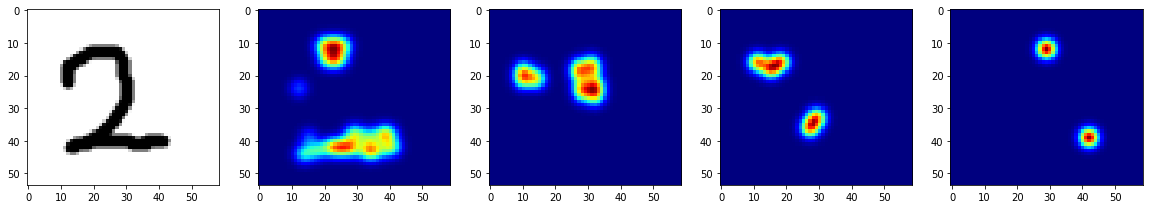

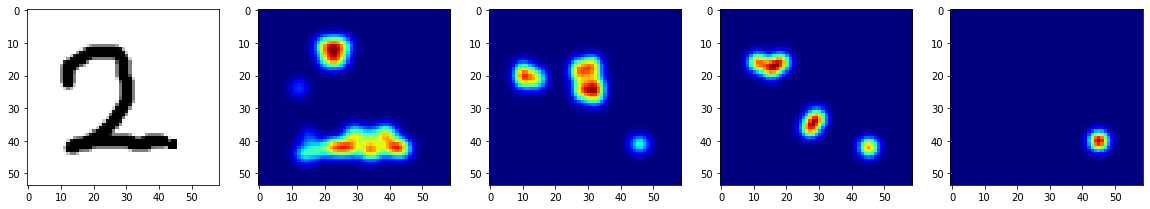

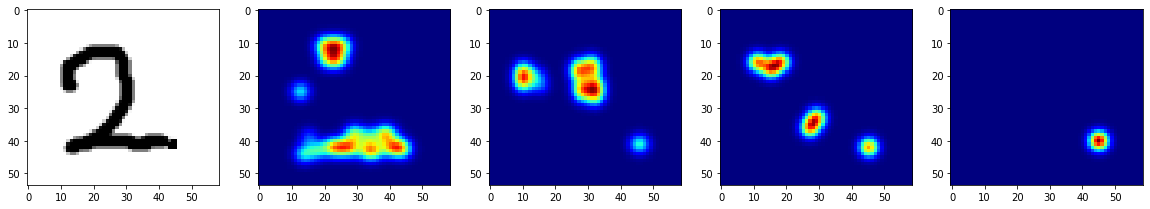

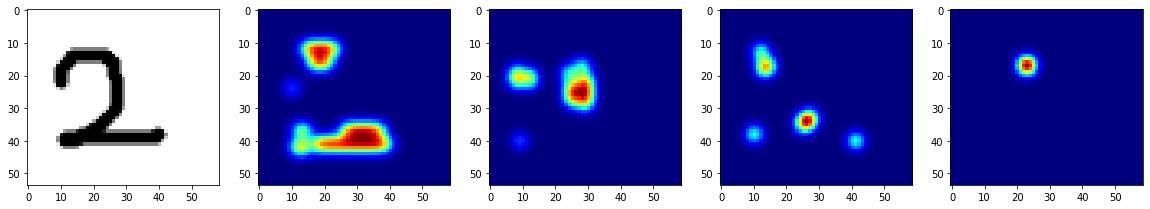

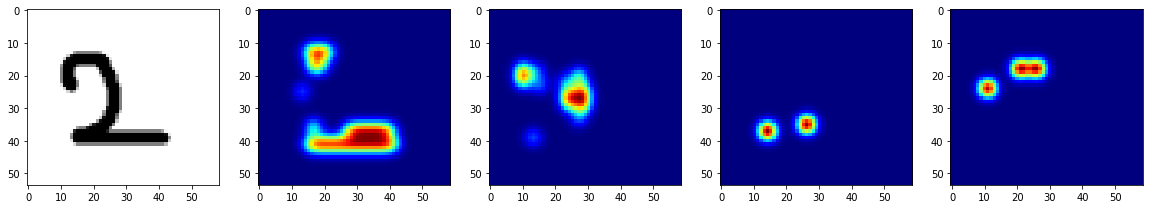

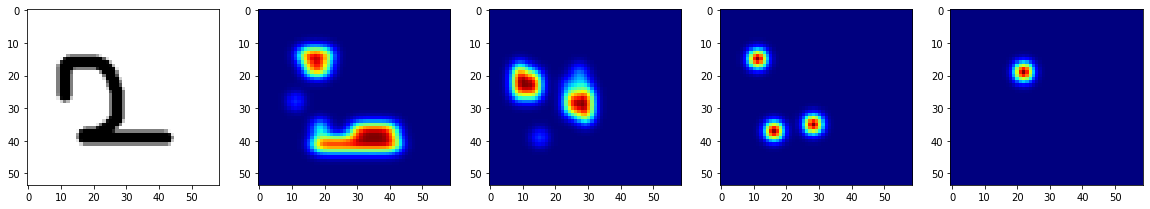

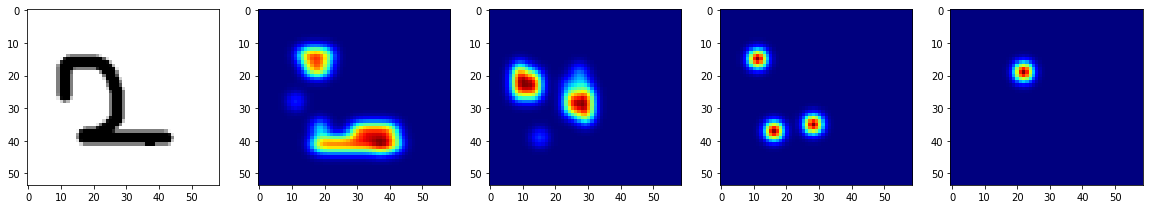

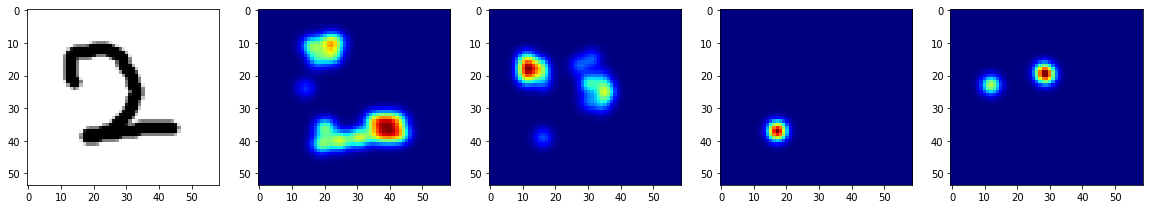

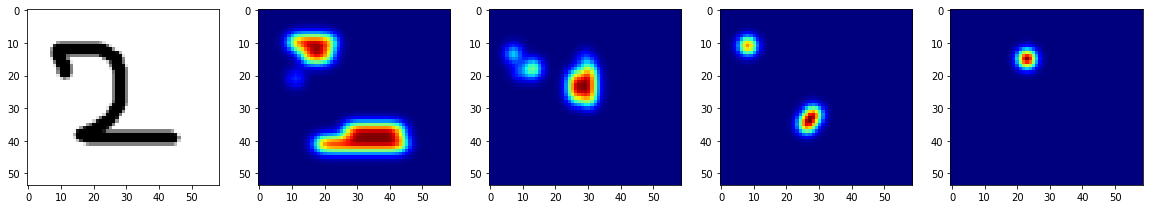

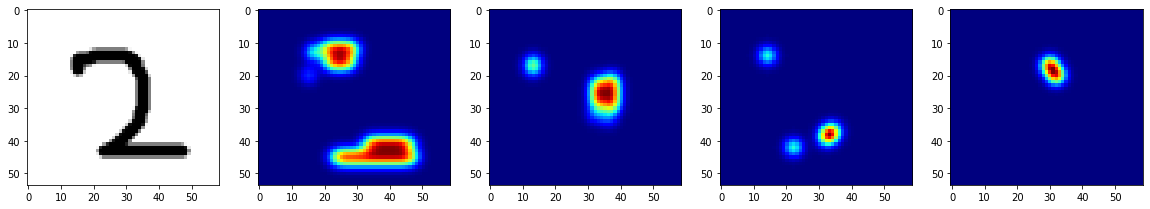

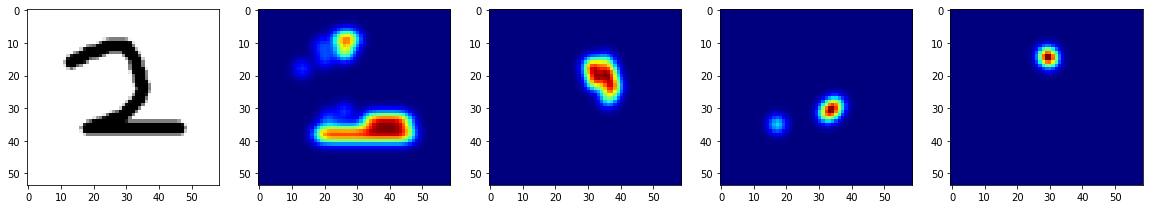

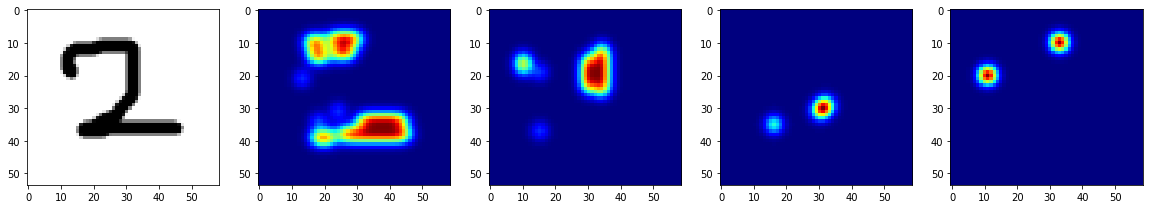

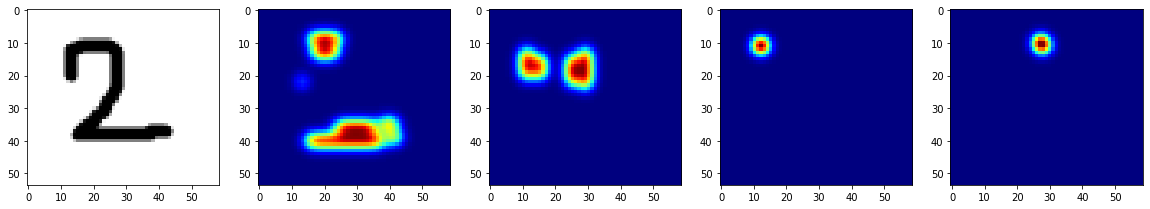

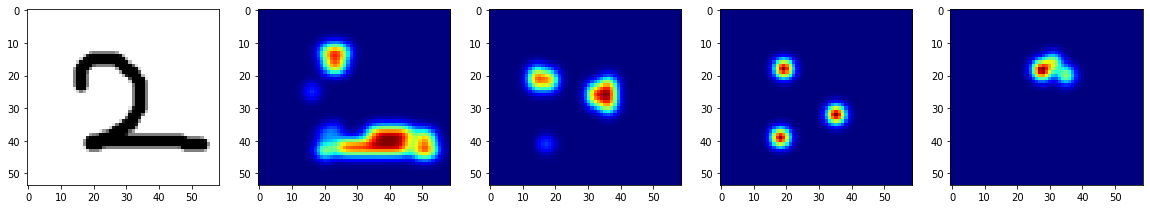

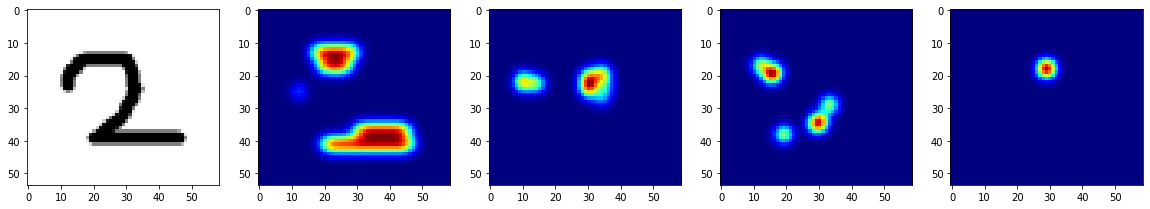

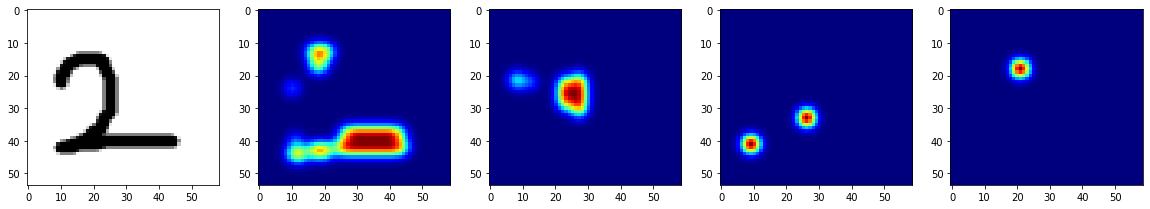

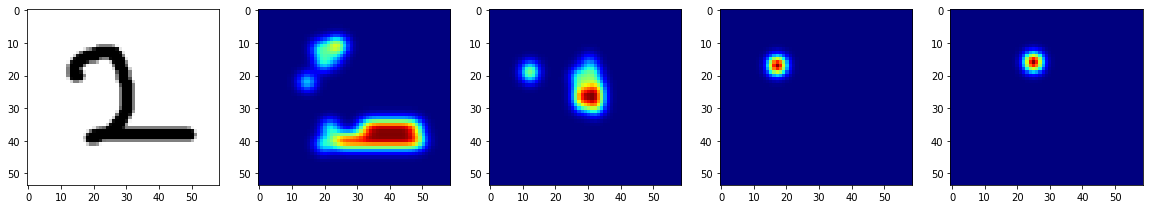

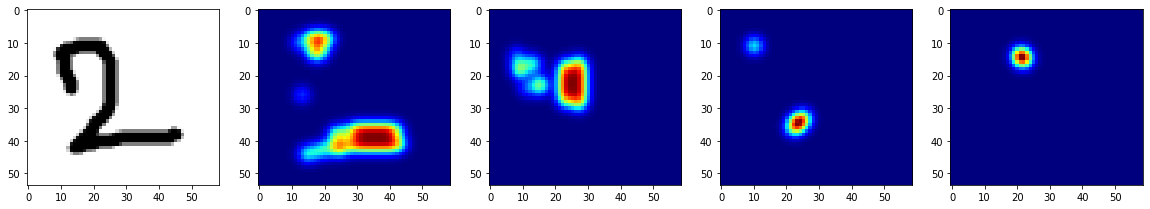

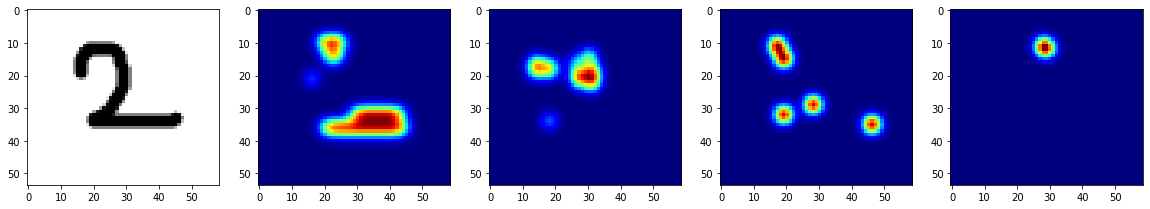

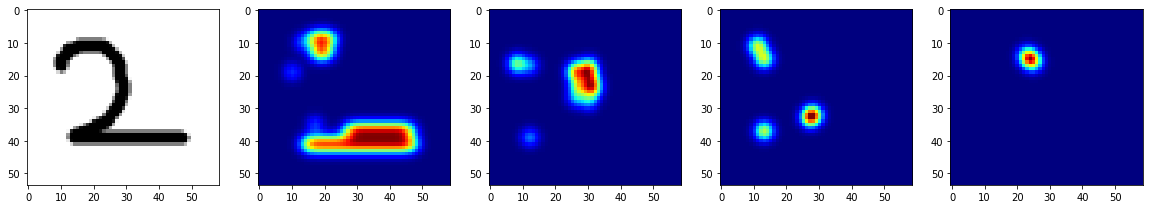

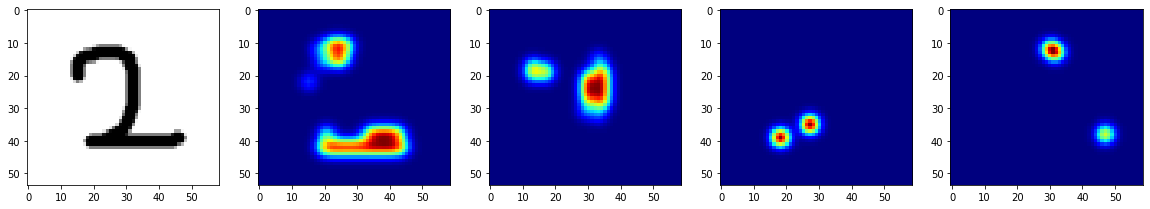

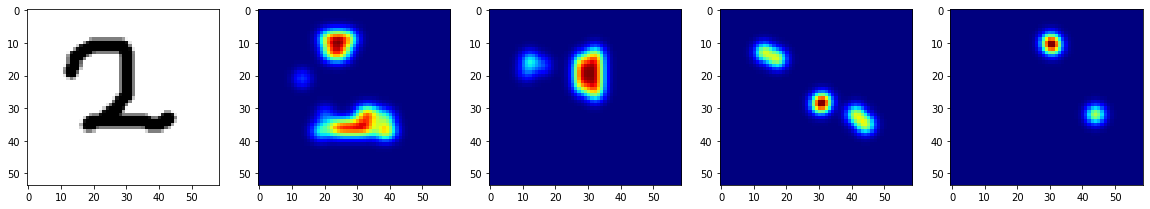

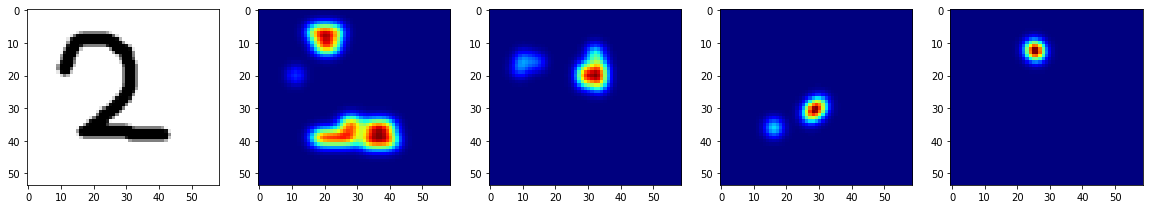

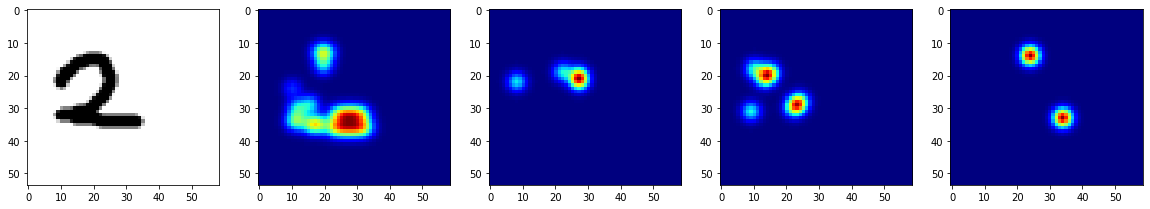

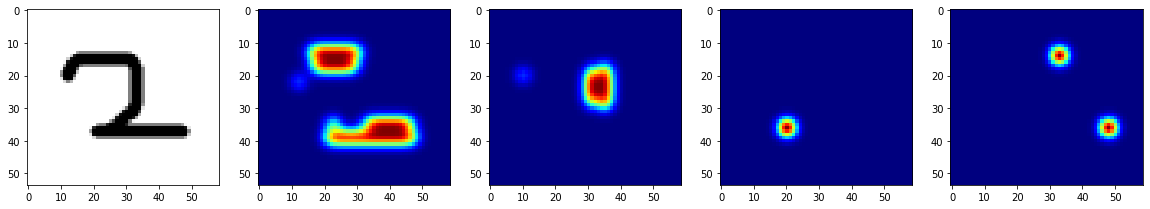

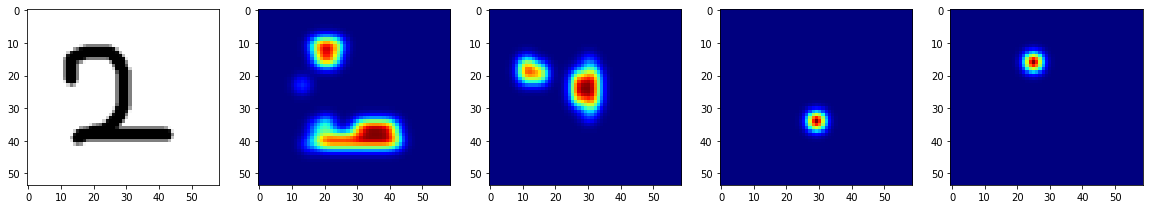

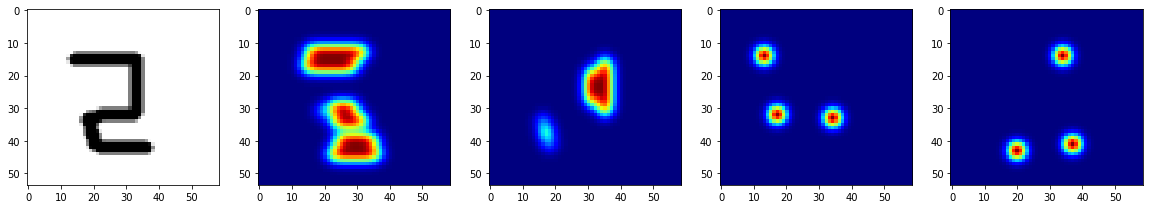

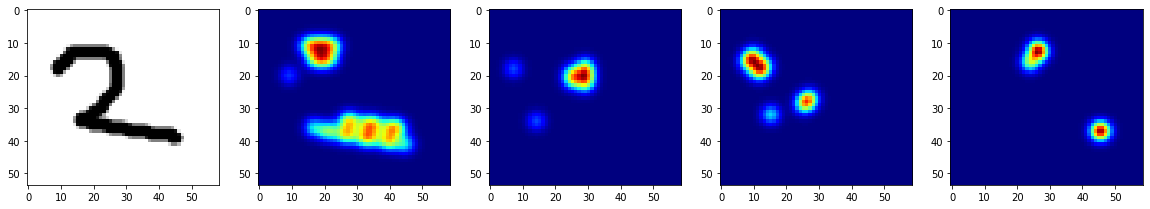

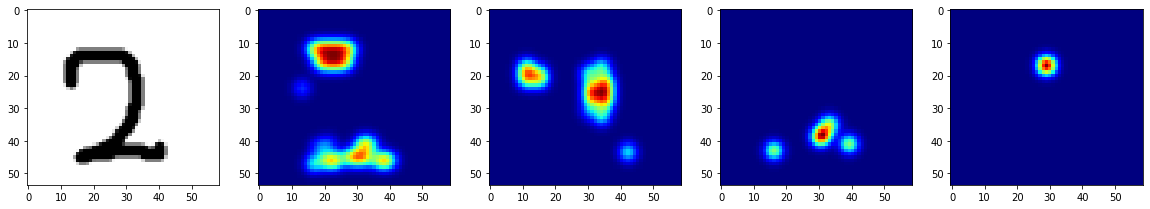

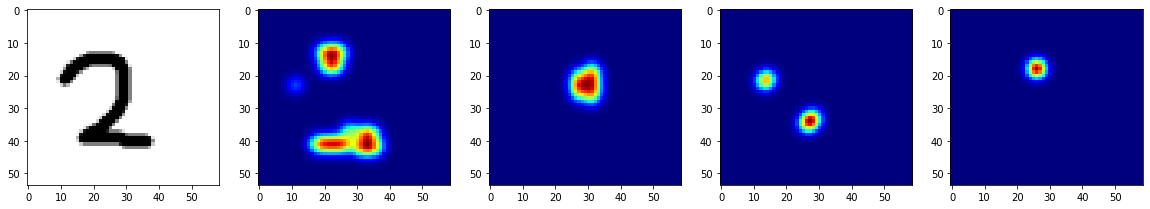

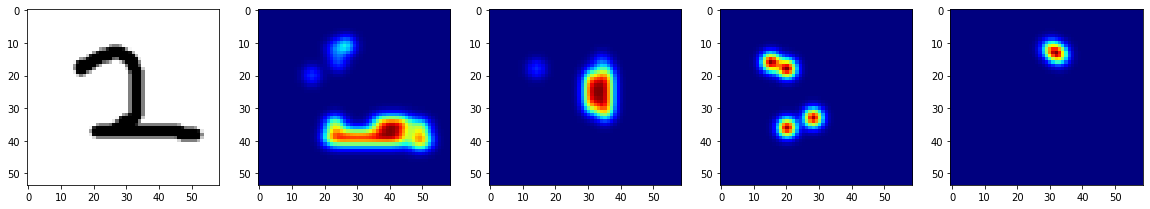

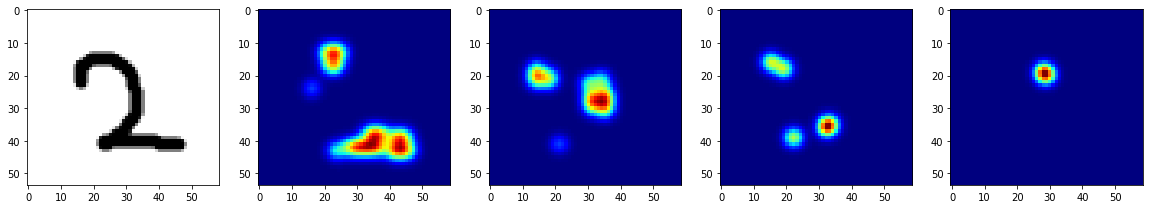

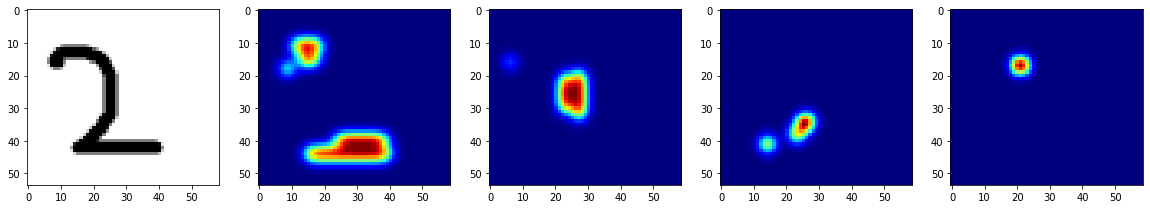

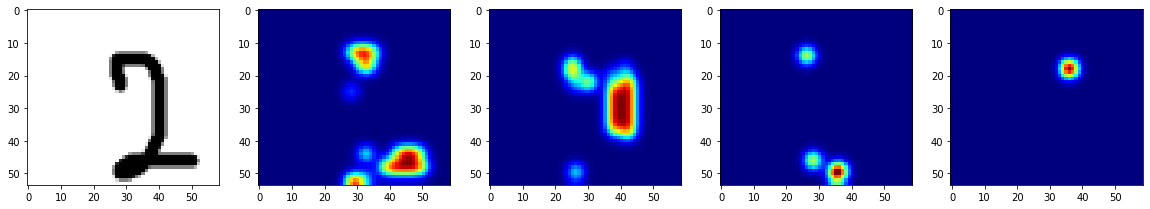

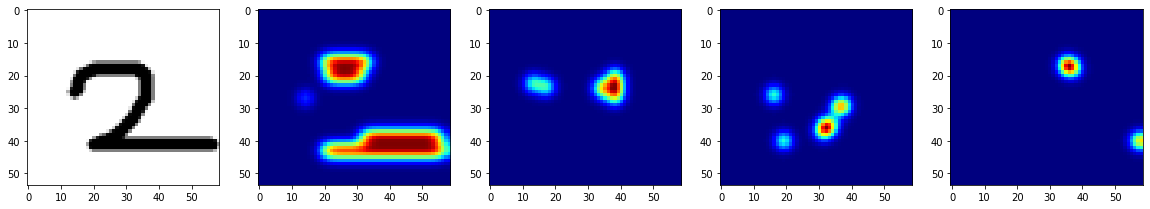

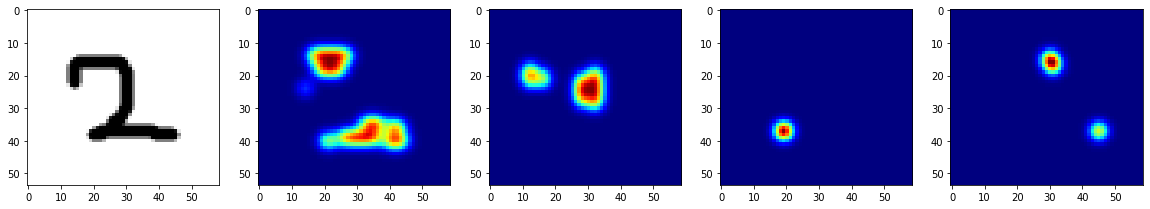

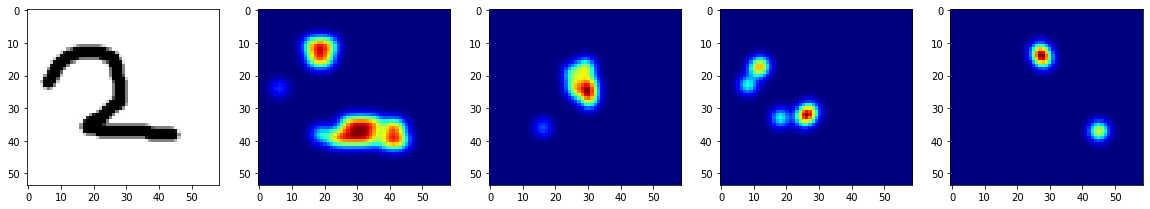

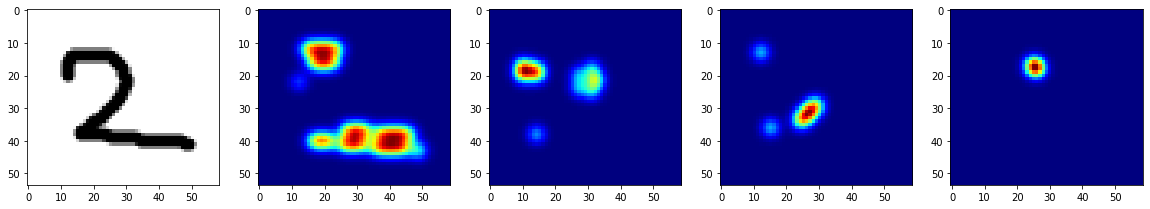

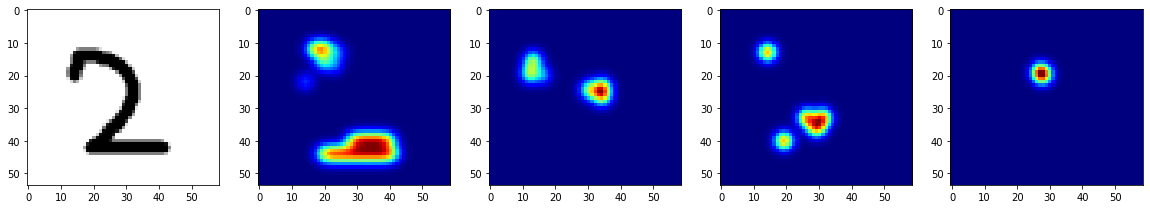

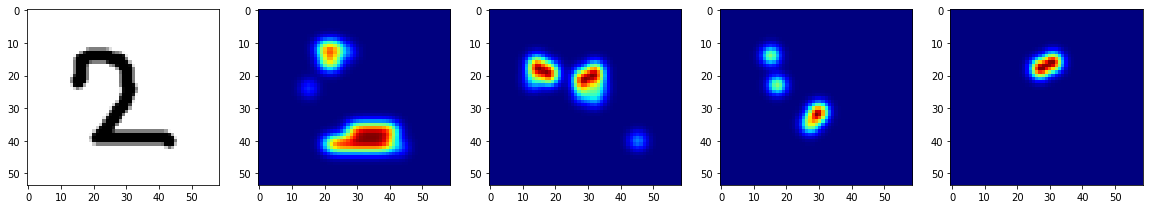

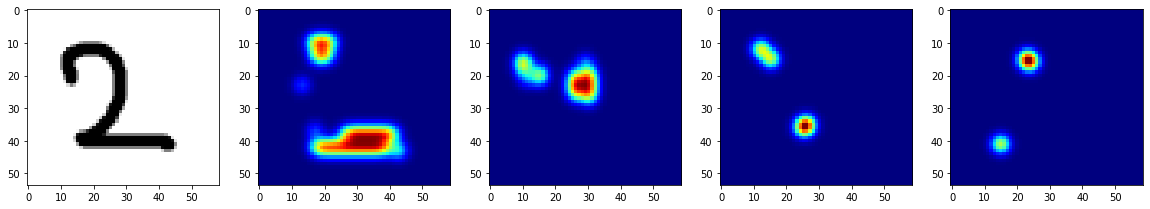

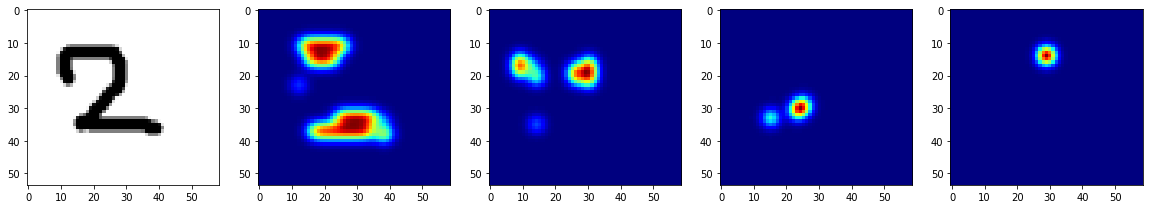

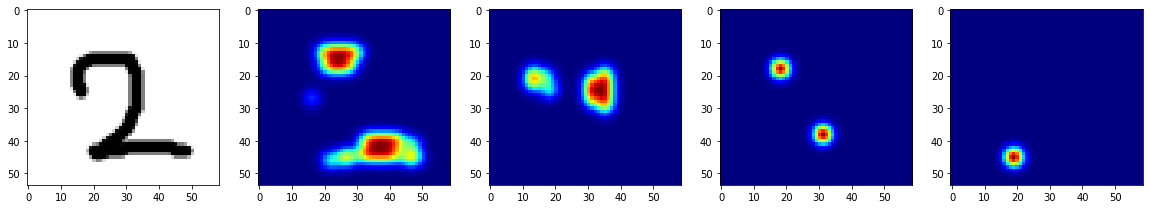

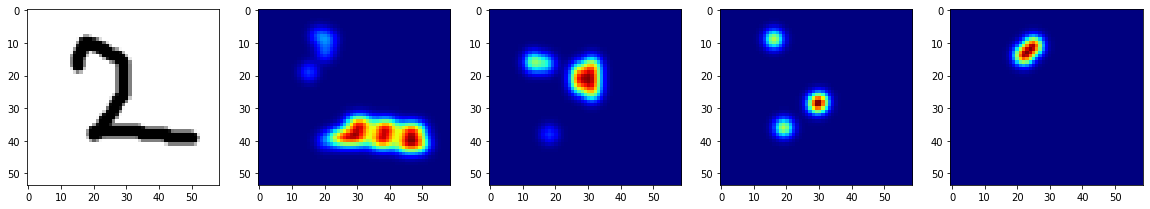

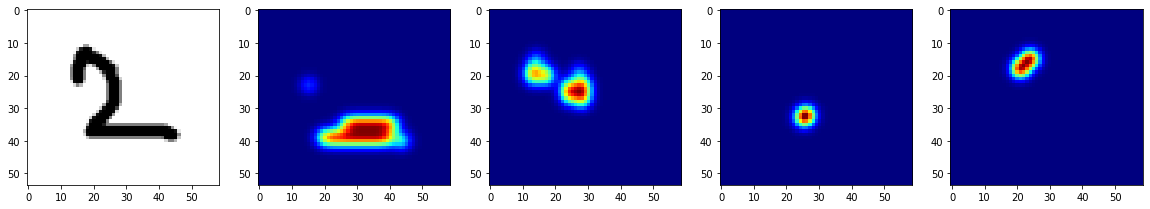

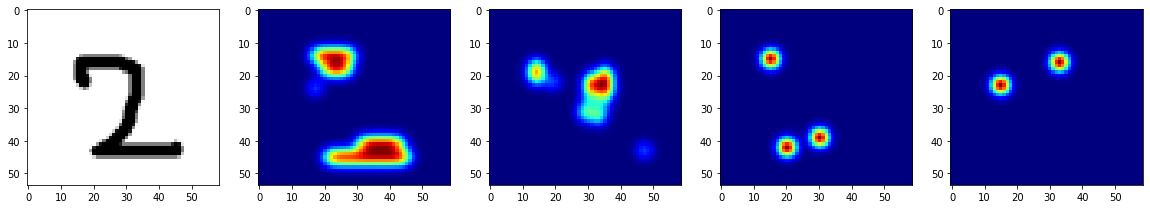

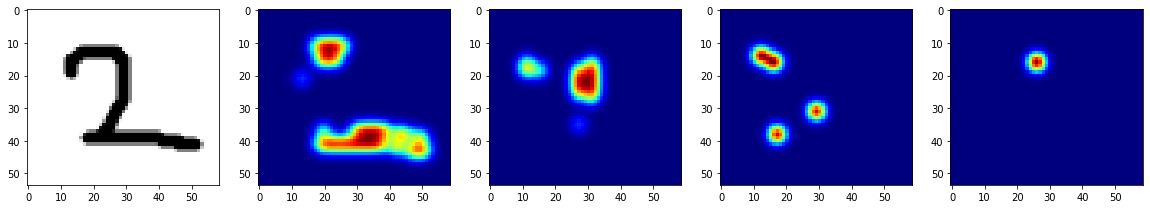

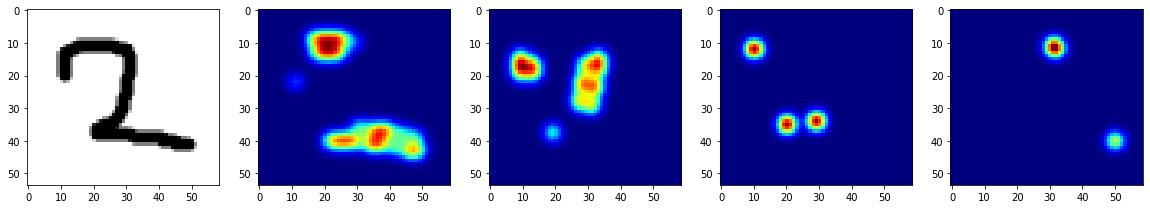

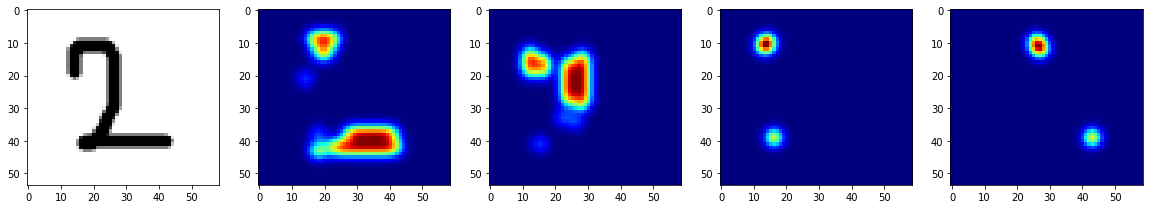

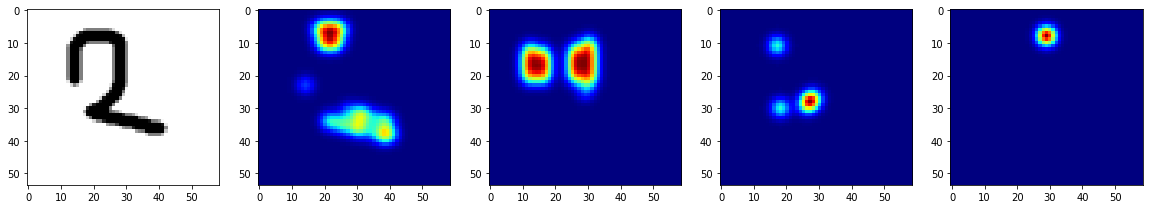

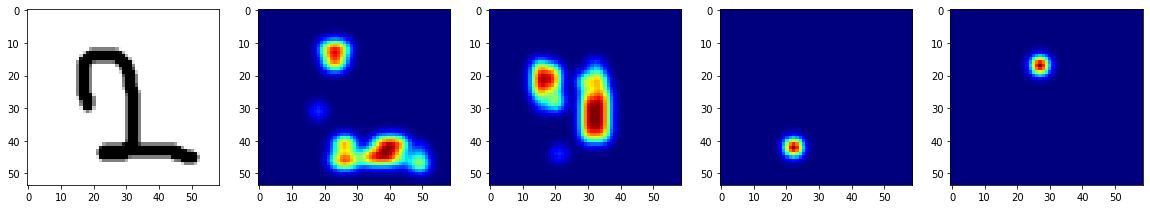

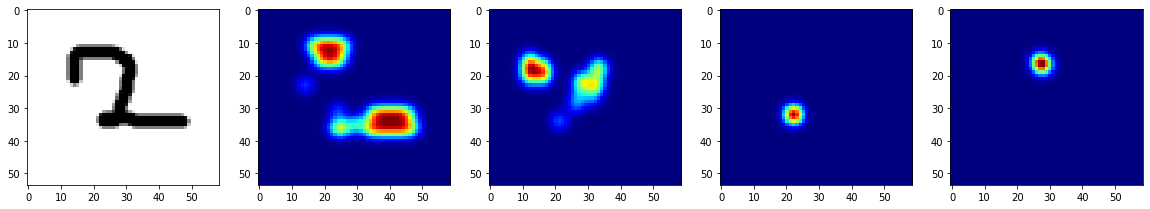

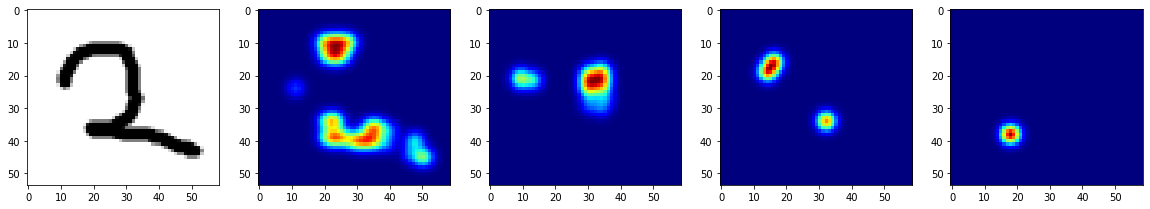

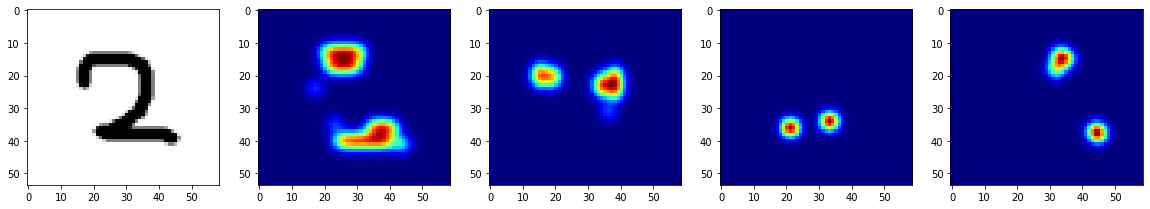

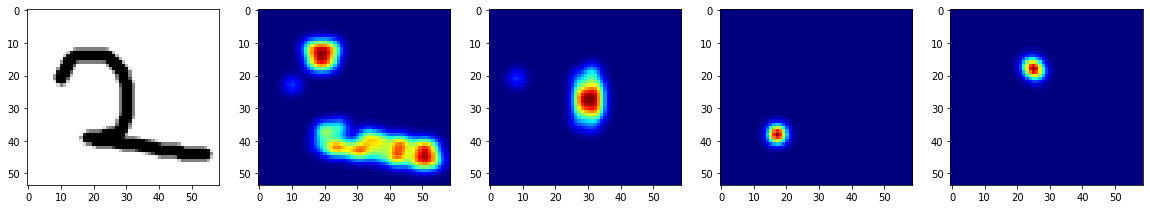

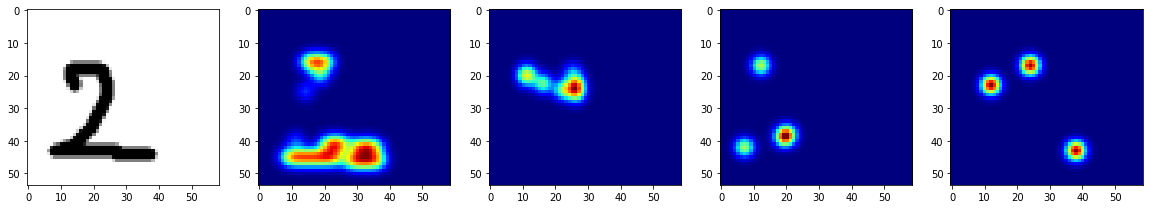

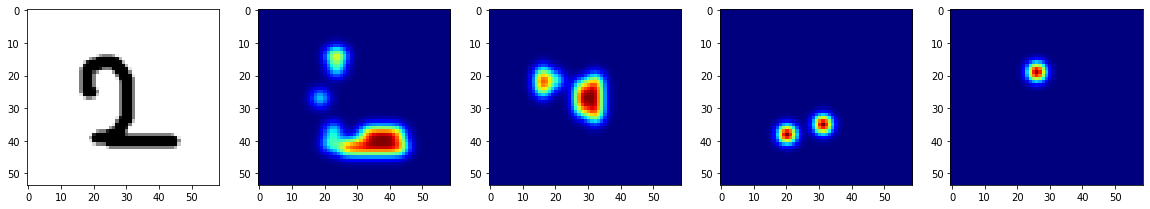

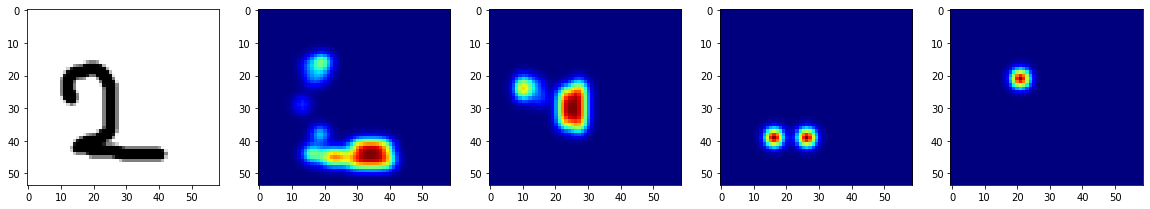

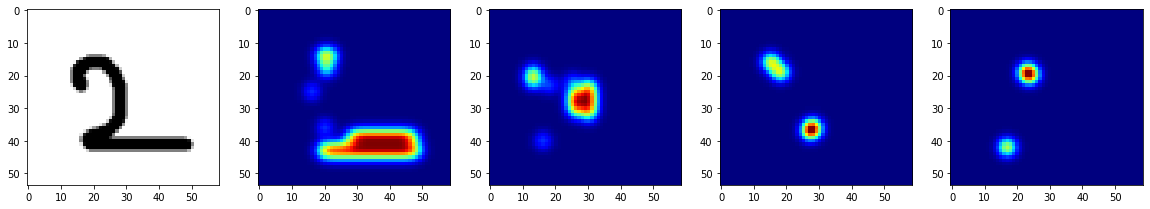

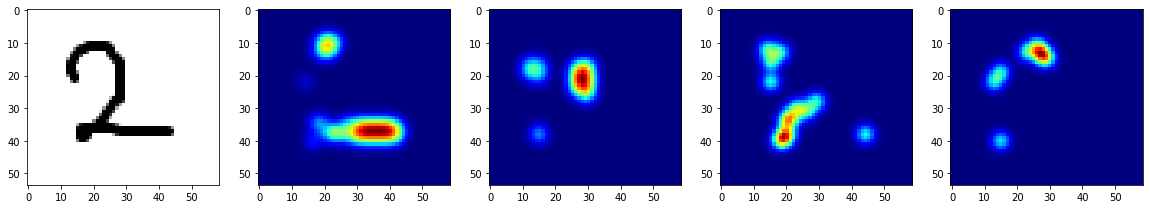

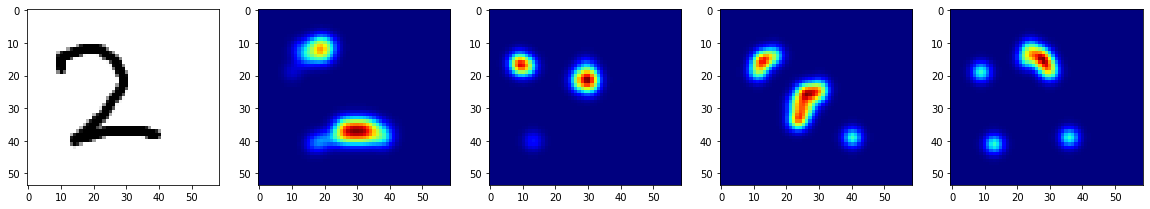

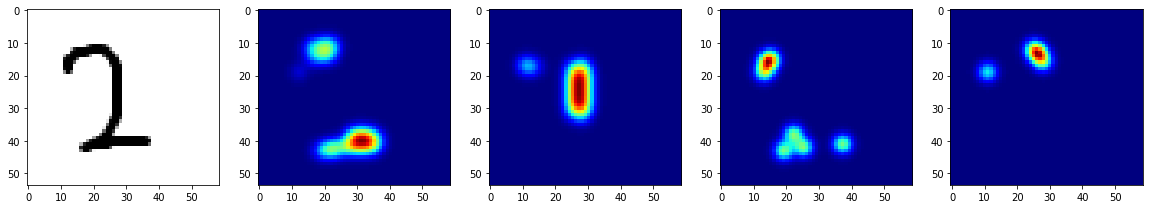

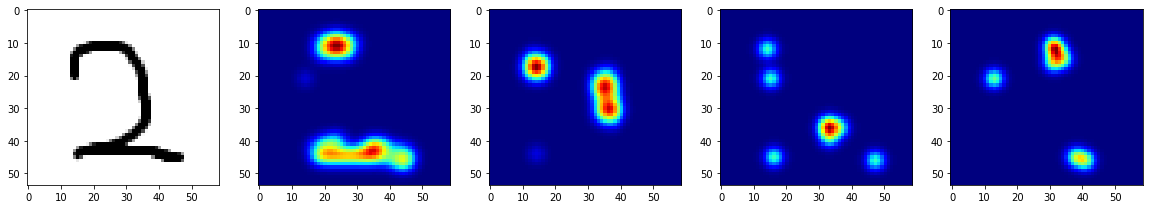

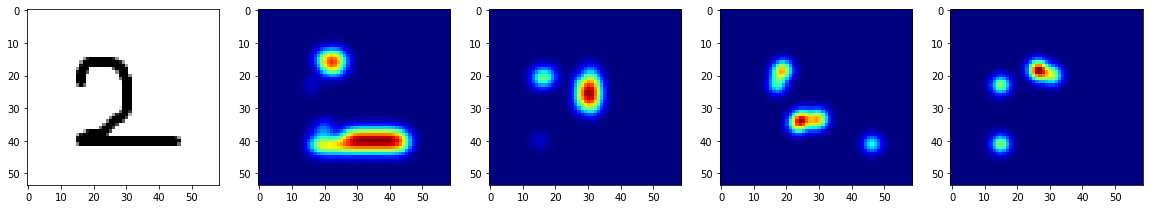

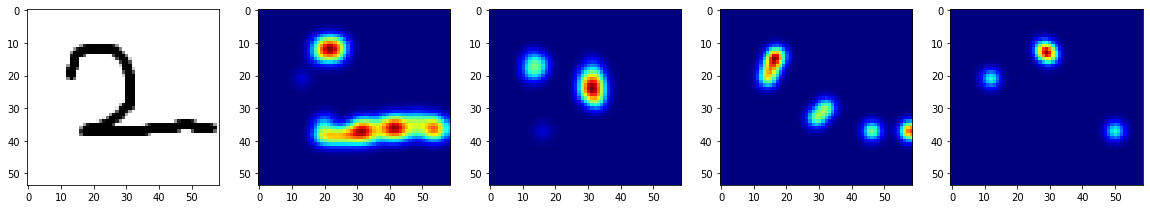

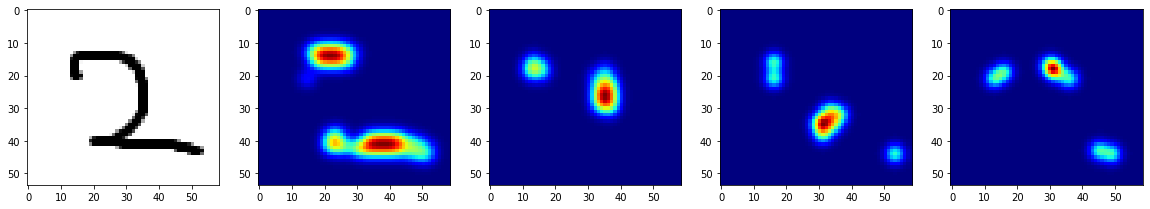

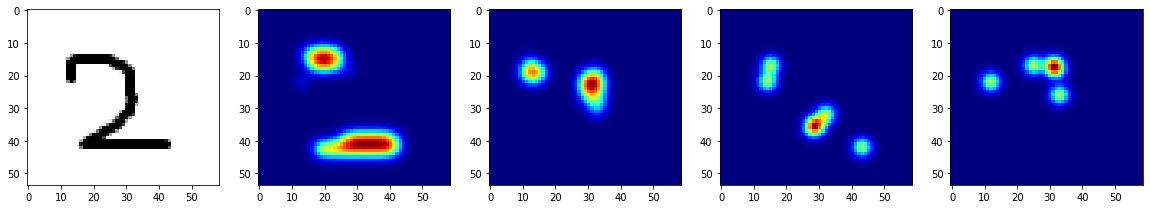

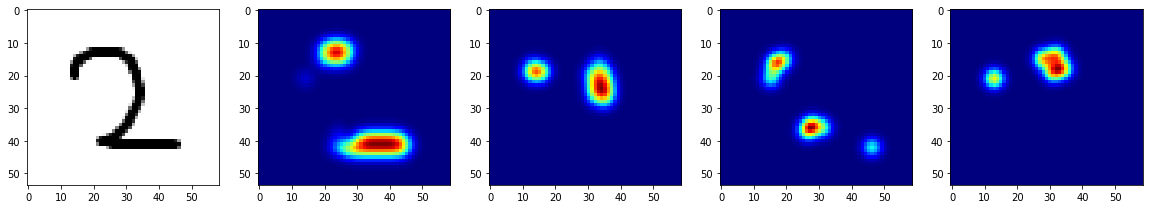

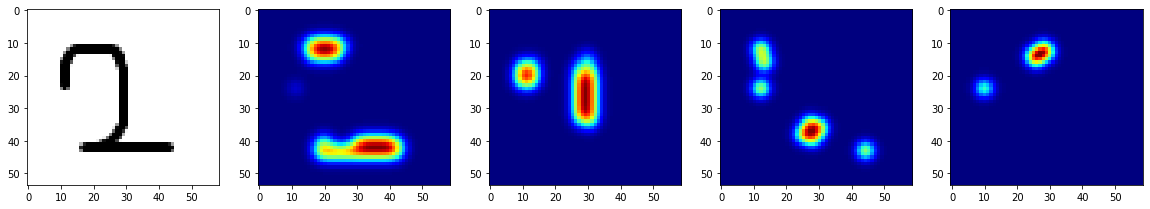

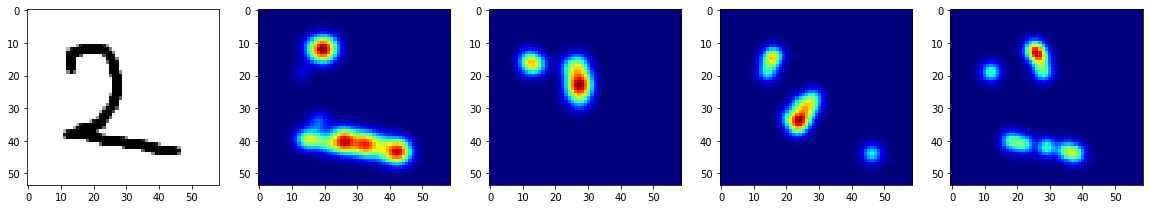

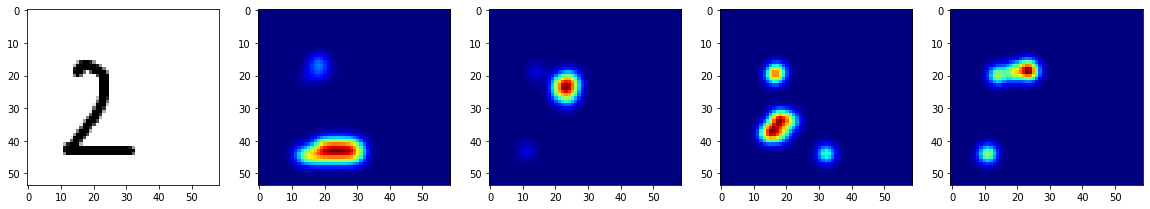

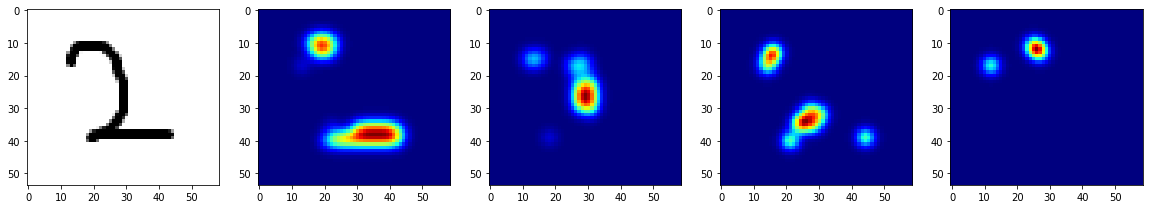

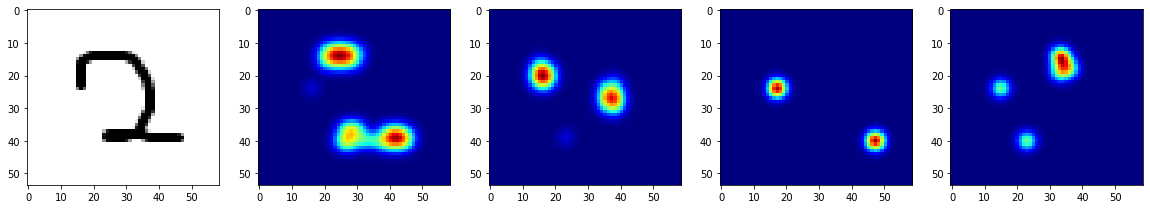

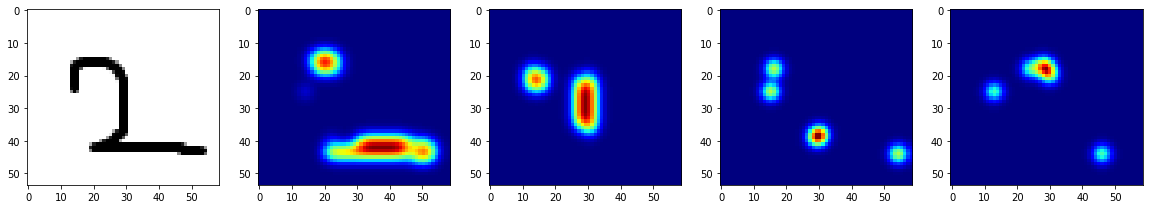

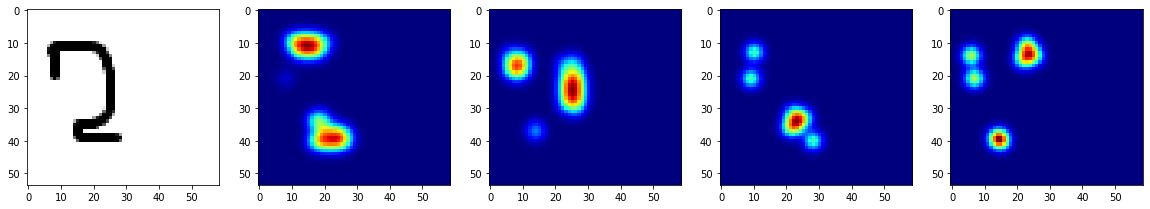

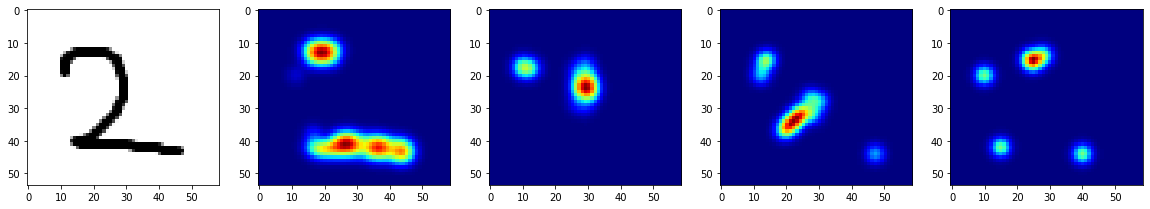

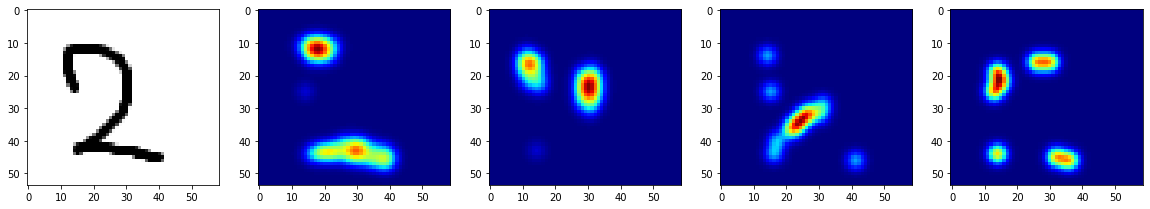

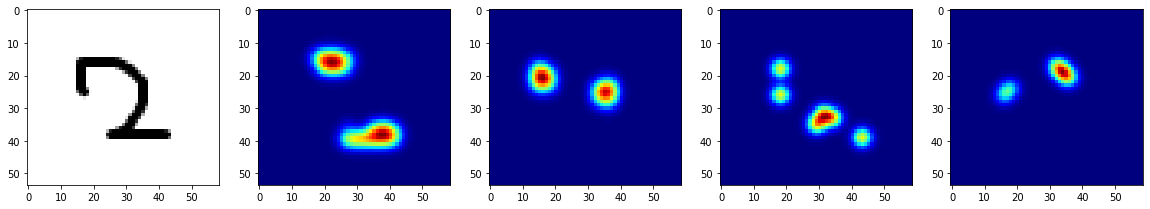

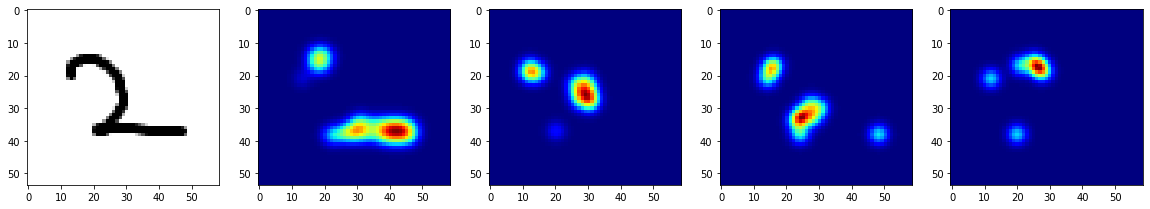

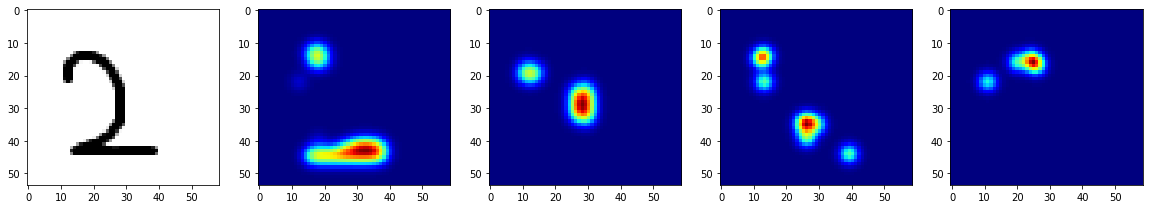

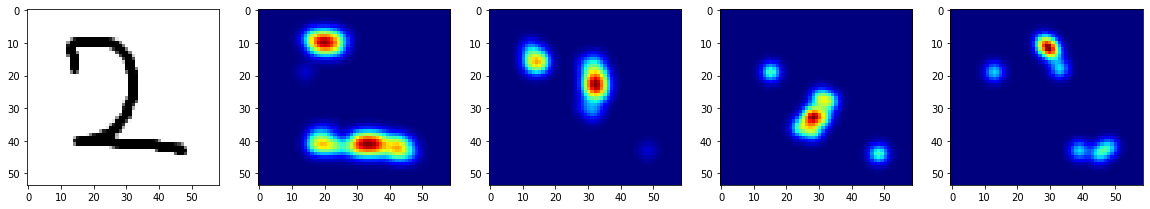

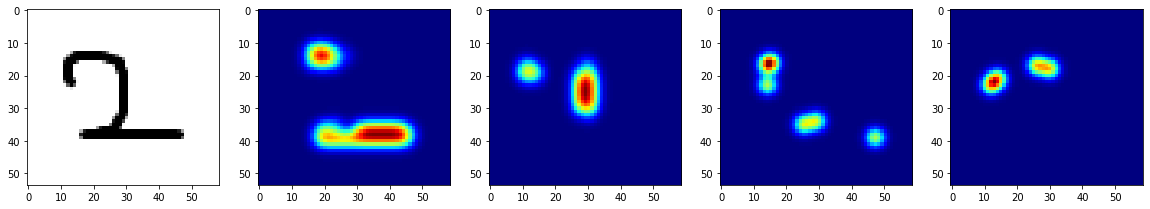

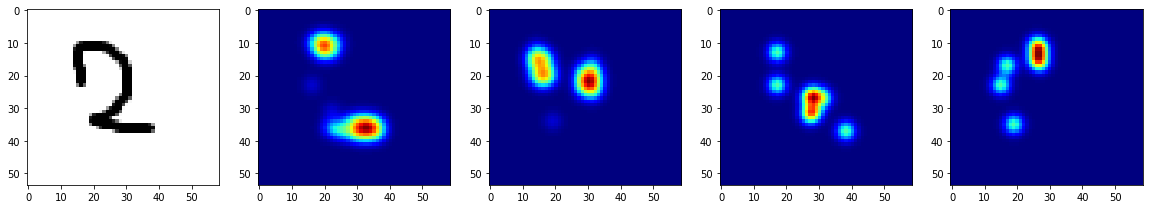

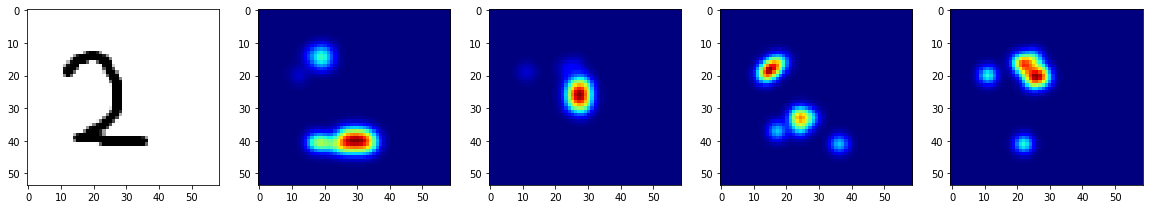

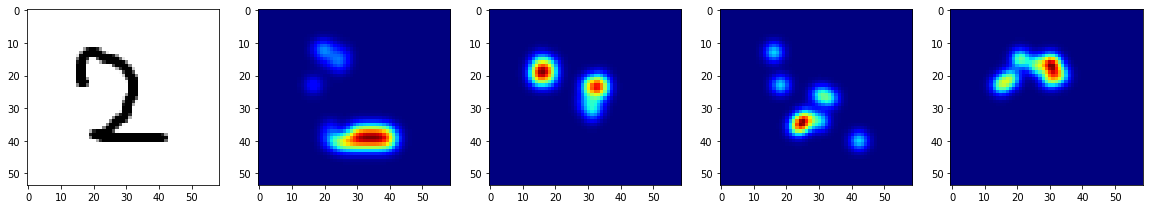

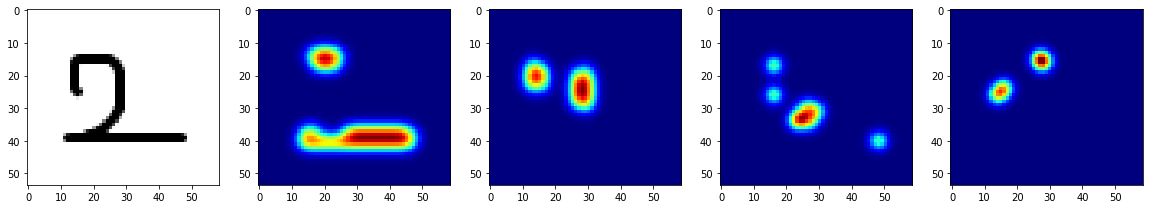

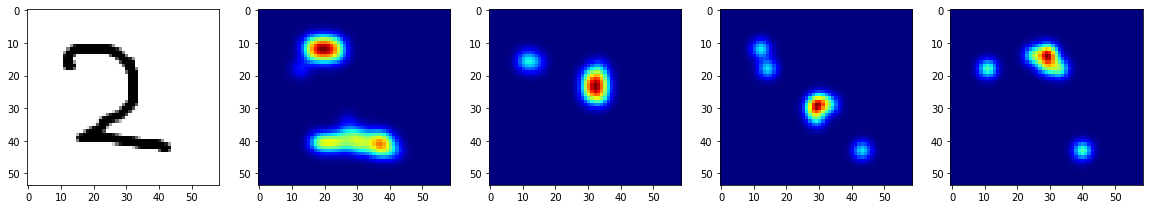

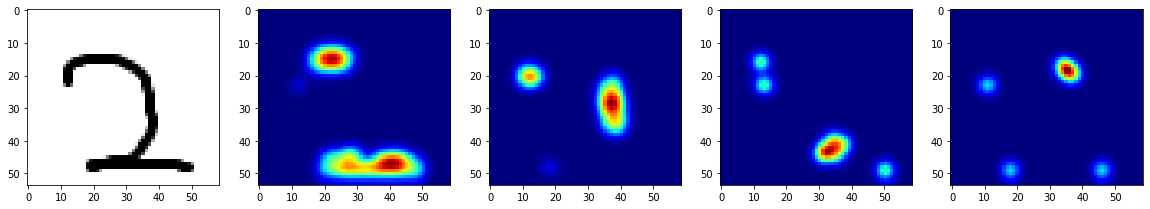

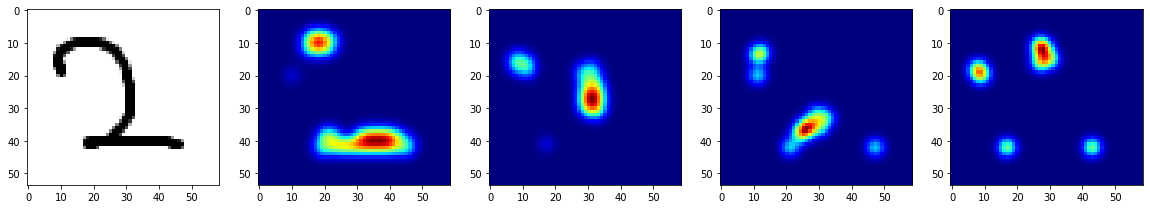

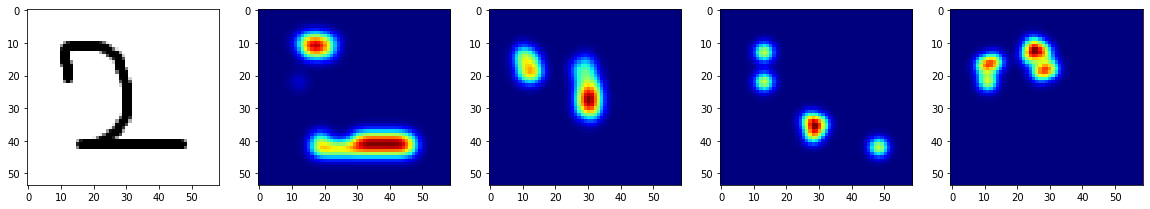

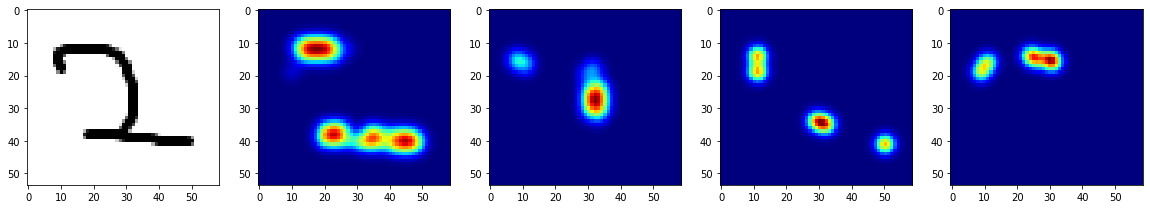

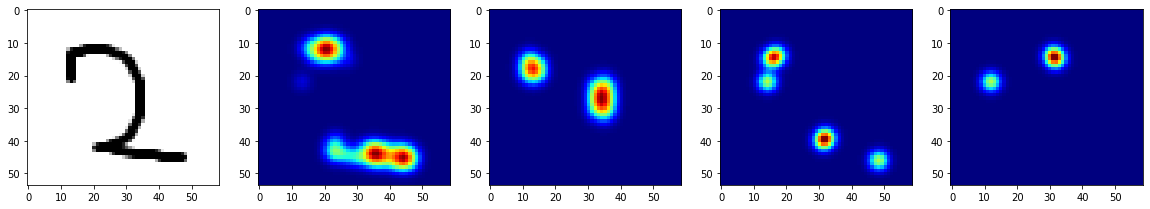

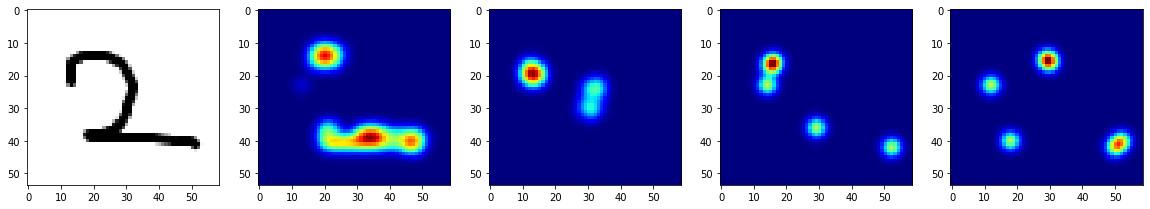

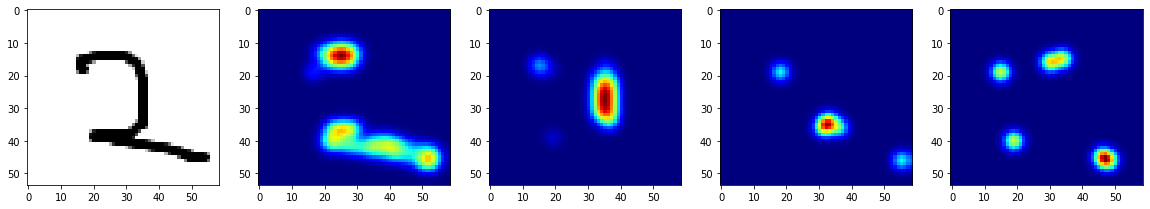

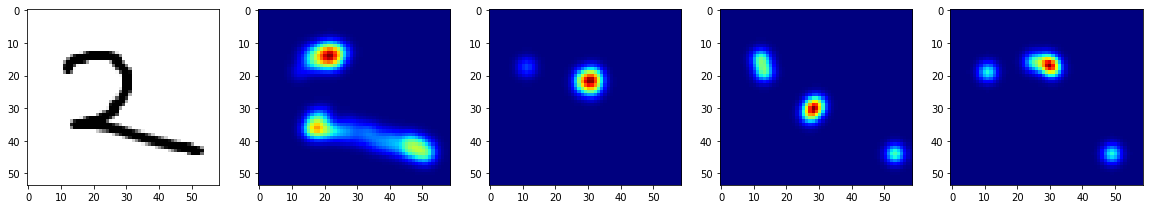

In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt

folder = r'D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/2/'
resFolder = r'D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/2r/'

#kernels(4)
sv = np.array([[-1,-2,-1],
              [0,0,0],
              [1,2,1]],np.float32)
sh=sv.T

sd1 = np.array([[-2,-1,0],
               [-1,0,1],
               [0,1,2]],np.float32)
sd2 =  np.array([[0,-1,-2],
               [1,0,-1],
               [2,1,0]],np.float32)
kernels = [sv,sh,sd1,sd2]



files = os.listdir(folder)
for fi in range(len(files)):
    dataImgName = files[fi]
    fig,ax = plt.subplots(1,5,figsize=(20,20))
    img = cv.imread(folder + dataImgName,0)
    assert img is not None
    img = np.array(img,np.float32)
    ax[0].imshow(img,cmap="gray")

    for i in range(len(kernels)):
        kernel = kernels[i]
        res = np.abs(cv.filter2D(img,-1,kernel))
       
        
        #cleaning the filtered result (res)
        resMax = np.max(res)
        considerable = res>resMax*0.99
        
        res *= considerable
        res = cv.GaussianBlur(res,(15,15),2)
        
        
        ax[i+1].imshow(res,cmap="jet")

        cv.imwrite(resFolder + dataImgName.split(".")[0] + "_" + str(i) + ".png",res)
    
    plt.show()
    #if fi >10:break
    

In [182]:
def createModel(imgFileNameList_,dataPath,outputPath,corrTres=0.8,shouldFitPercentage=1,imshow=0,returnModels=1):
    totalDataCount = len(imgFileNameList_)
    imgFileNameList = imgFileNameList_.copy()
    
    
    models = []
    filesLeft_prevIter = len(imgFileNameList)+1 #to see if file count reduces with each iterration
    corrs_last =[]
    
#     for i in range(len(imgFileNameList)):
#         thisFileName = imgFileNameList[i]
#         dataImg = cv.imread(dataPath + thisFileName, 0).astype(np.float32)
#         assert dataImg is not None
#         dataImg /= np.sum(dataImg)
        
#         if not i:
#             models.append(dataImg)
#         else:
#             models[-1] += dataImg
    
    while imgFileNameList:
        print("files left=",len(imgFileNameList))
        if filesLeft_prevIter > len(imgFileNameList):
            filesLeft_prevIter = len(imgFileNameList)
            for i in range(len(imgFileNameList)):
                thisFileName = imgFileNameList[i]
                dataImg = cv.imread(dataPath + thisFileName, 0).astype(np.float32)
                assert dataImg is not None
                dataImg /= np.sum(dataImg)

                if not i:
                    models.append(dataImg)
                else:
                    models[-1] += dataImg
            
            #keeping only significant ponits
            models[-1] *= models[-1]>np.max(models[-1])* 0.1

            #checking whether the model can generalize all data images
            corrs =[]    
            for i in range(len(imgFileNameList)):
                thisFileName = imgFileNameList[i]
                dataImg = cv.imread(dataPath + thisFileName, 0).astype(np.float32)
                dataImg /= np.sum(dataImg)

                thisTestingModel = models[-1]
                dataImg_dev = dataImg - np.mean(dataImg)
                thisTestingModel_dev = thisTestingModel - np.mean(thisTestingModel)
                corr = sig.correlate2d(dataImg_dev,thisTestingModel_dev) /np.sqrt(np.sum(dataImg_dev**2) * np.sum(thisTestingModel_dev**2))

                corrs.append(np.max(corr))
            print(corrs)
            corrs_last = corrs


            imgFileNameList = [imgFileNameList[i] for i in range(len(imgFileNameList)) if corrs[i] < corrTres]



            #print("-----------------------done------------------")
        #--- endOf :if file count drops => 
        else:  #file count stayed the same
            if shouldFitPercentage > 1-(len(imgFileNameList)/totalDataCount):
                maxCorrOfLeftIndex = corrs_last.index(max(corrs_last)) # max corelated one ;(can expect this is the most probably corelated one to others => good as a model)
                maxCorrImage = cv.imread(dataPath + imgFileNameList[maxCorrOfLeftIndex], 0).astype(np.float32)
                assert dataImg is not None
                /#maxCorrImage /= np.sum(maxCorrImage)
                models.append(maxCorrImage)
                #have to remove this data image from the list => so file count drops => will try to correlate with opthers
                imgFileNameList = [imgFileNameList[i] for i in range(len(imgFileNameList)) if i != maxCorrOfLeftIndex]
            else:
                break
    print("------------------------------------------successfully generated --------------------------------------")          
    if imshow:
        fig,ax = plt.subplots(len(models),1,figsize=(100,20))
        for i in range(len(models)):
            ax[i].imshow(models[i],cmap="jet")
            ax[i].xaxis.tick_top()
        plt.show()
    
    if outputPath and outputPath is not None:
        for i in range(len(models)):
            thisModel = np.array(models[i]*255/np.max(models[i]),dtype=np.uint8)
            cv.imwrite(outputPath + "model_" + str(i) + ".png",thisModel)
    

    if returnModels:
        return models
        


In [187]:
folder = r'D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/2/'
resFolder = r'D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/2r/'

files = os.listdir(resFolder)
svf = [file for file in files if (file.split("_")[1].split(".png")[0]=="0")]
shf = [file for file in files if (file.split("_")[1].split(".png")[0]=="1")]
sd1f = [file for file in files if (file.split("_")[1].split(".png")[0]=="2")]
sd2f = [file for file in files if (file.split("_")[1].split(".png")[0]=="3")]


createModel(imgFileNameList_=svf,dataPath=resFolder,
            outputPath="D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/out/sv/",corrTres=0.8,shouldFitPercentage=0.9,returnModels=0)
createModel(imgFileNameList_=shf,dataPath=resFolder,
            outputPath="D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/out/sh/",corrTres=0.8,shouldFitPercentage=0.9,returnModels=0)
createModel(imgFileNameList_=sd1f,dataPath=resFolder,
            outputPath="D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/out/sd1/",corrTres=0.7,shouldFitPercentage=0.9,returnModels=0)
createModel(imgFileNameList_=sd2f,dataPath=resFolder,
            outputPath="D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/out/sd2/",corrTres=0.7,shouldFitPercentage=0.9,returnModels=0)

files left= 95
[0.87507415, 0.8975337, 0.8915832, 0.9127862, 0.9178336, 0.8909886, 0.8907157, 0.8668105, 0.90791917, 0.8774377, 0.88602626, 0.8910979, 0.9330445, 0.8881543, 0.92961043, 0.87969387, 0.88516, 0.8899889, 0.8654696, 0.89638096, 0.9107111, 0.82957244, 0.886339, 0.69384414, 0.8323317, 0.93390423, 0.67900443, 0.89346915, 0.7302436, 0.82128125, 0.8331371, 0.90022457, 0.87418383, 0.6645783, 0.8364471, 0.8236302, 0.90852684, 0.92066187, 0.887183, 0.9142794, 0.9264284, 0.82209665, 0.90380377, 0.8006973, 0.79955167, 0.9193087, 0.92531604, 0.89615583, 0.8896175, 0.83966804, 0.85472584, 0.7546301, 0.82668066, 0.82748264, 0.77490735, 0.85529387, 0.8707434, 0.8638452, 0.8744352, 0.9325521, 0.9092215, 0.86381435, 0.7524306, 0.91044146, 0.8029207, 0.89925164, 0.9443187, 0.9285069, 0.87152904, 0.8629871, 0.7798844, 0.92835325, 0.8905327, 0.85686684, 0.7429292, 0.90902776, 0.80243456, 0.81235075, 0.78766024, 0.8844954, 0.8325193, 0.9072041, 0.8599971, 0.8643107, 0.89373523, 0.87179255, 0.9

[0.64753705, 0.5254692, 0.56475, 0.55693585, 0.5745932, 0.52413976, 0.5585332, 0.40650123, 0.5217953, 0.596484, 0.64599395, 0.48568818, 0.6375337, 0.45609197, 0.5268949, 0.53295606, 0.49137905, 0.5731473, 0.55889434, 0.6136839, 0.4755839, 0.5731913, 0.52562225, 0.60729533, 0.59958917, 0.54922074, 0.6307248, 0.47485664, 0.52340865, 0.530049, 0.5377712, 0.5247173, 0.576272, 0.61476403, 0.5314678, 0.5354827, 0.5305156, 0.54639274, 0.34611446, 0.5957287, 0.614882, 0.6158984, 0.61276907, 0.5466357, 0.64789087, 0.50589275, 0.47345835, 0.5222888, 0.587899]
files left= 49
files left= 48
[0.64456445, 0.51605844, 0.553707, 0.54606944, 0.5674042, 0.5146775, 0.5672591, 0.4169874, 0.5123211, 0.5856587, 0.6456686, 0.48117372, 0.63304824, 0.45123222, 0.51750535, 0.52354836, 0.5010934, 0.57403016, 0.555148, 0.6041278, 0.46721062, 0.56580955, 0.5162085, 0.59657335, 0.5883446, 0.538235, 0.6269336, 0.46493608, 0.51401556, 0.52080667, 0.5350246, 0.5153039, 0.5705538, 0.6090199, 0.53394264, 0.52514774, 0.5

[0.4845526, 0.544669, 0.50622135, 0.5459946, 0.47358763, 0.43951872, 0.47780848, 0.5359298, 0.44636026, 0.41200656, 0.4828295, 0.47592655, 0.52612406, 0.521573, 0.46159083, 0.55195683, 0.48455256, 0.48477185, 0.42563194, 0.47798377, 0.47776872, 0.5295008, 0.48365277, 0.514248, 0.50783426, 0.32365757, 0.5553321, 0.54651767, 0.50522447, 0.49989673, 0.4630846, 0.50657266]
files left= 32
files left= 31
[0.49607742, 0.5452675, 0.50793326, 0.5516631, 0.48513827, 0.4512151, 0.48952228, 0.54115826, 0.44381452, 0.4035947, 0.49438116, 0.485586, 0.5243441, 0.52776664, 0.4572067, 0.5477263, 0.49607736, 0.49656653, 0.43616527, 0.4896168, 0.48939967, 0.5250941, 0.49519122, 0.51313245, 0.49933335, 0.33196145, 0.54030496, 0.50956917, 0.5000215, 0.46118516, 0.49536577]
files left= 31
files left= 30
[0.49636573, 0.5227912, 0.4787144, 0.486368, 0.4203019, 0.4905477, 0.5407485, 0.4264266, 0.40488005, 0.4963044, 0.4870695, 0.5322701, 0.50025165, 0.4537882, 0.5187956, 0.49801534, 0.49768272, 0.43792084, 0.4

[0.52371556, 0.49911627, 0.5872566, 0.39707413, 0.5373381, 0.40645698, 0.62484235, 0.5682345, 0.6142001, 0.5616383, 0.57687235, 0.5757405, 0.5572611, 0.49831462, 0.6115731, 0.55413175, 0.61748034, 0.55945015, 0.6375341, 0.6209816, 0.56576383, 0.49768454]
files left= 22
files left= 21
[0.5466796, 0.48364744, 0.5985896, 0.40827897, 0.5521697, 0.42870015, 0.63463473, 0.56876814, 0.5866543, 0.5775187, 0.59688455, 0.5864049, 0.52800936, 0.50176114, 0.62420374, 0.5463753, 0.6031698, 0.54416853, 0.5933849, 0.5568456, 0.5001685]
files left= 21
files left= 20
[0.54348516, 0.5157761, 0.59238225, 0.41826633, 0.52494144, 0.45152128, 0.5432083, 0.6152761, 0.5900101, 0.6015173, 0.5889951, 0.5217062, 0.5121149, 0.6063608, 0.53720367, 0.6045586, 0.5579821, 0.57907915, 0.56832135, 0.5142111]
files left= 20
files left= 19
[0.55645716, 0.49849364, 0.5925572, 0.41878748, 0.52739716, 0.4593496, 0.572841, 0.595773, 0.6059249, 0.5757062, 0.51500446, 0.50692147, 0.6081081, 0.55571973, 0.6129958, 0.53115195, 0

### these masks/kernels made,are not found in the order of relatedness. Better to sort them by how many data-images resulted in each mask.

In [201]:
def getRelatedness(testImg,modelFolderList,folderPath):
    resultsForEachModel = []
    for i in range(len(modelFolderList)):
        thisFolder = os.listdir(folderPath + modelFolderList[i])
        
        kernel = kernels[i]
        res = np.abs(cv.filter2D(testImg,-1,kernel))
       
        
        #cleaning the filtered result (res)
        resMax = np.max(res)
        considerable = res>resMax*0.99
        
        res *= considerable
        res = cv.GaussianBlur(res,(15,15),2)
        
        for modelFileNameIndex in range(len(thisFolder)):
            modelFileName = thisFolder[modelFileNameIndex]
            model= cv.imread(folderPath +modelFolderList[i] + "/" +  modelFileName,0).astype(np.float32)
            #model /= np.sum(model)
            
            model_dev = model-np.mean(model)
            res_dev = res-np.mean(res)
            corr = sig.correlate2d(model_dev,res_dev)/np.sqrt(np.sum(model_dev**2) * np.sum(res_dev**2))
            #print("max",np.max(corr))

            #corr = np.corrcoef(model,res)
            #plt.imshow(corr),plt.show()
#             plt.imshow(model),plt.show()
#             plt.imshow(res),plt.show()
            
            maxCorr = np.max(corr)
            if not modelFileNameIndex:
                resultsForEachModel.append([maxCorr])
            else:
                resultsForEachModel[-1].append(maxCorr)
    return resultsForEachModel
            
        
        
        
        
    
    

In [202]:
testImg = cv.imread("D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/2/1649782640.3786013.png",0)
assert testImg is not None

modelFolder = "D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/out/"

resultsForEachModel = getRelatedness(testImg,modelFolderList=["sv","sh","sd1","sd2"],folderPath=modelFolder)

for results in resultsForEachModel:
    print("result = ",max(results))






result =  0.7851054788917113
result =  0.6659966017917206
result =  0.5894645683850095
result =  0.7083621927431017


In [203]:
testImg = cv.imread("D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/4/1649783263.4869983.png",0)
assert testImg is not None

modelFolder = "D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/out/"

resultsForEachModel = getRelatedness(testImg,modelFolderList=["sv","sh","sd1","sd2"],folderPath=modelFolder)

for results in resultsForEachModel:
    print("result =", max(results))




result = 0.6983719280020989
result = 0.5134696932577081
result = 0.6111501098638901
result = 0.5107336326799501


# <span class="burk">Finding uncorrelated Kernels</span>

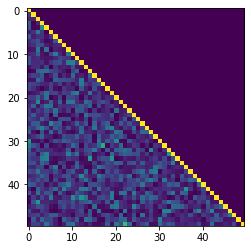

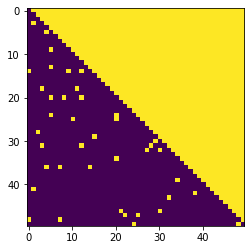

In [12]:
#generating eigen kernels by rendomly generating and checking for low corelation

kernelCount =50

kernelList =[]

for i in range(kernelCount):
    candKernel= np.random.rand(5,5)
    candKernel-=np.mean(candKernel)
    kernelList.append(candKernel)

    
#checking
corrNorms=np.zeros((kernelCount,kernelCount))
for i in range(len(kernelList)):
    for j in range(i+1):
        kernel1 = kernelList[i]
        kernel2 = kernelList[j]
        corrNorm = np.sum(kernel1*kernel2) / np.sqrt(np.sum(kernel1**2)*np.sum(kernel2**2))
        corrNorms[i,j]=abs(corrNorm)


        
plt.imshow(corrNorms)
plt.show()
jsonStr = json.dumps(corrNorms.tolist())
# print(jsonStr)

# print(corrNorms)


uncorrelated = corrNorms<0.01
plt.imshow(uncorrelated)
plt.show()




Image 1 : correlation matrix (only first triangle) <br/>
Image 2 : yellow = uncorrelated ones (| $\sigma$ | < 0.01)

### Visualizing all uncorrelated kernel-pairs

In [13]:
#visualizing uncorrelated kernels as pairs

#turn on or off visualizing

# for i in range(len(kernelList)):
#     for j in range(i+1):
#         if uncorrelated[i,j]:
#             fig,ax = plt.subplots(1,2)
#             ax[0].imshow(kernelList[i],cmap="gray")
#             ax[1].imshow(kernelList[j],cmap="gray")
#             plt.show()
                
print("done")

done


### Finding Eigen kernels (kernel sets which are uncorrelated)

In [14]:
#selecting uncorrelated kernels
selected = []
for i in range(len(kernelList)):
    for j in range(i+1):
        if uncorrelated[i,j]:
            if i not in selected:
                selected.append(i)
            if j not in selected:
                selected.append(j)

#checking if eigen
tres =0.01
eigens = []

for i in range(len(selected)):
    isEigen =1
    for j in range(len(selected)):
        if i!=j:
            kernel1 = kernelList[i]
            kernel2 = kernelList[j]
            corrNorm = np.sum(kernel1*kernel2) / np.sqrt(np.sum(kernel1**2)*np.sum(kernel2**2))
            corrNormAbs=abs(corrNorm)
            if corrNormAbs > tres:
                isEigen=0
    if isEigen:
        eigens.append(i)

        

            
            
            

In [15]:
#visualizing eigen kernels
print("there are ",len(eigens)," eigen kernels")
for i in eigens:
    fig,ax = plt.subplots()
    ax.imshow(kernelList[i],cmap="gray")
    plt.show()


there are  0  eigen kernels


In [16]:
def checkUncorr(thisCand,valid):
    isOK=1
    for i in range(len(valid)):
        thisTesterKernel = valid[i]
        corrNorm = np.sum(thisTesterKernel*thisCand) / np.sqrt(np.sum(thisTesterKernel**2)*np.sum(thisCand**2))
        if corrNorm > 0.01:
            isOK=0
            break
    return isOK


superSets =[]
def giveEigenSuperSet(cand,valid=[]):
    if (len(cand)==0):
        superSets.append(valid)
    if len(valid) == 0:
        for i in range(len(cand)-1):
            giveEigenSuperSet(cand[i+1:],cand[i])
    else:
        for i in range(len(cand)-1):
            thisCand = cand[i]
            if checkUncorr(thisCand,valid):
                giveEigenSuperSet(cand[i+1:],valid+[thisCand])
            else:
                superSets.append(valid)
    
                

In [17]:
selectedKernels = [kernelList[x] for x in selected]
giveEigenSuperSet(selectedKernels)

In [18]:
print(len(selected))
print(len(superSets))


38
299800


In [20]:
superSets = [set for set in superSets if len(set)>1]

In [21]:
superSets[0]

array([[ 0.14995163, -0.44745542,  0.1465506 , -0.16334646,  0.06426896],
       [ 0.20792615,  0.33496764, -0.08828651,  0.16745541,  0.50946135],
       [ 0.51456563,  0.05667619,  0.25654067, -0.39111526, -0.33880265],
       [-0.31190776, -0.43716889, -0.39527962,  0.34055173,  0.4164015 ],
       [ 0.09919126,  0.02466885, -0.16929613, -0.42154958, -0.12496928]])

### Eigen  kernel generation - attempt 02

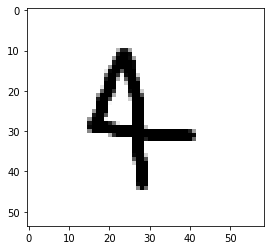

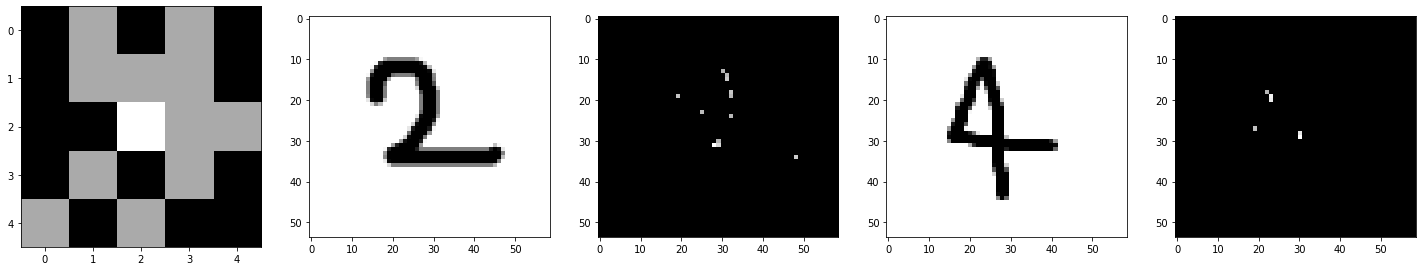

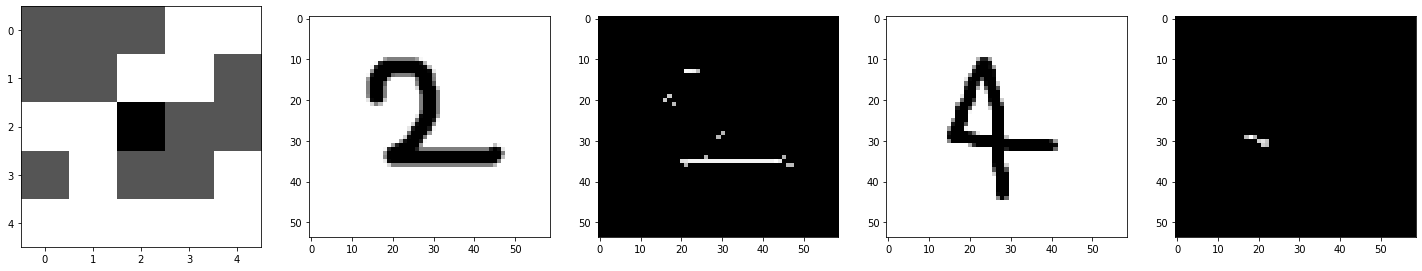

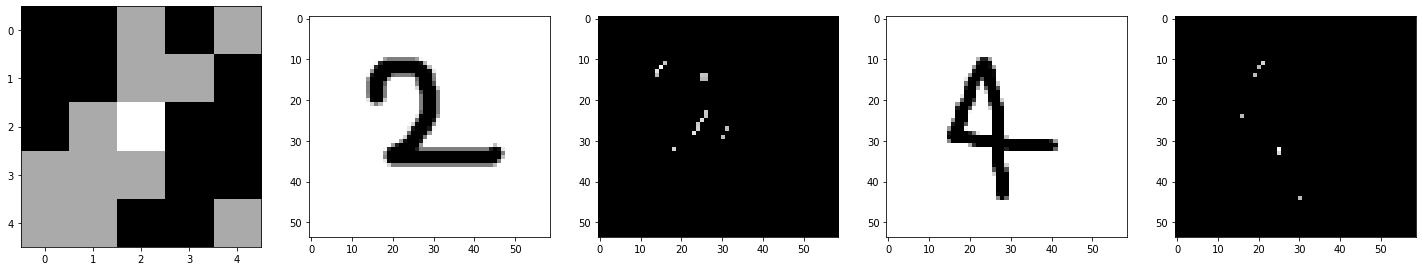

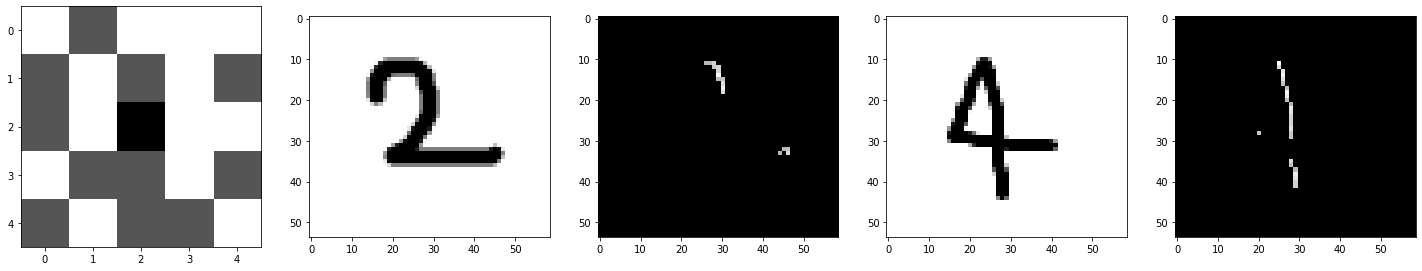

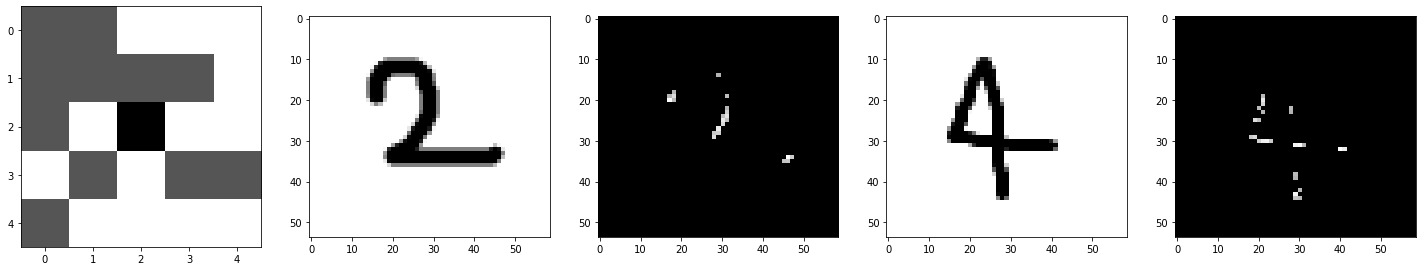

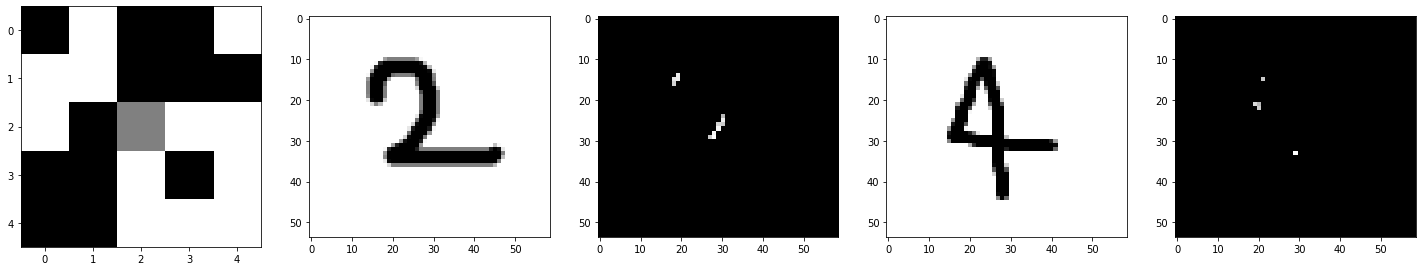

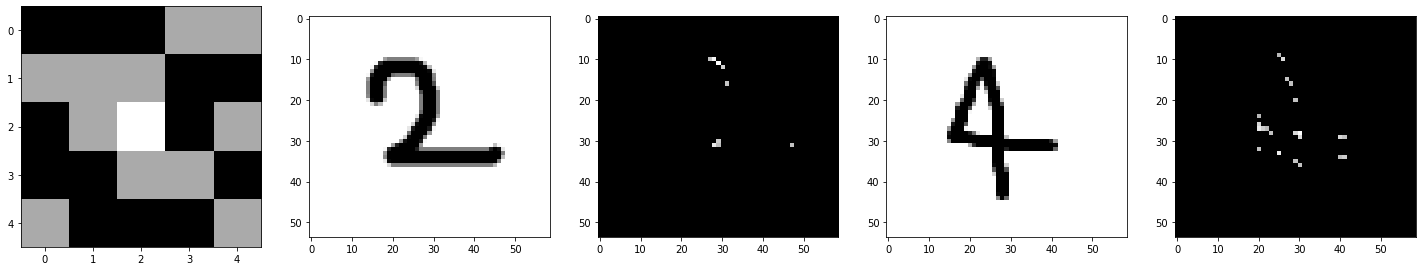

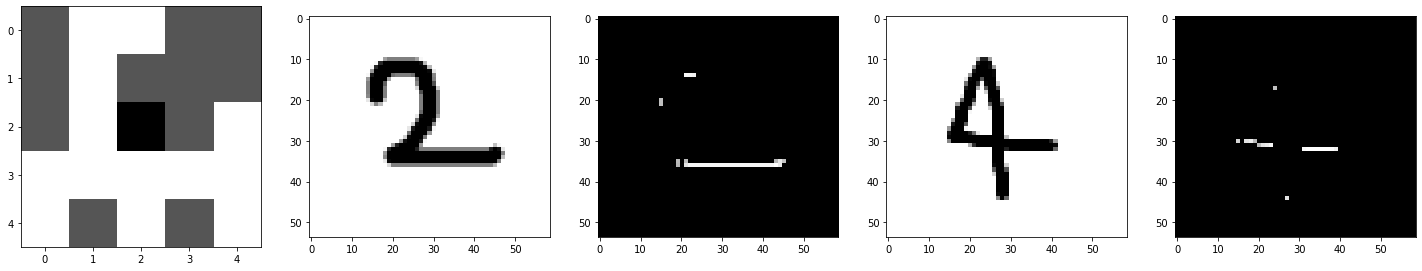

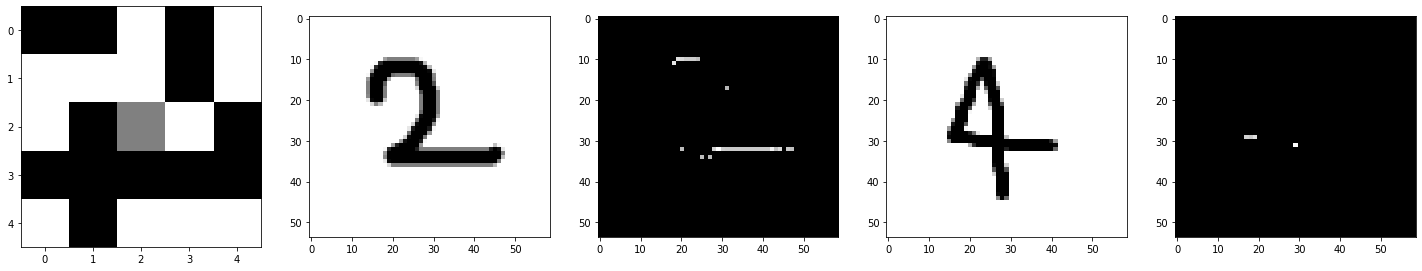

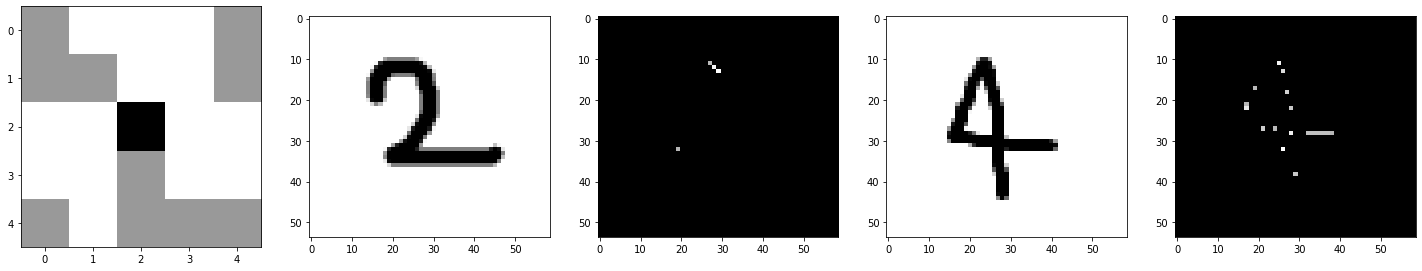

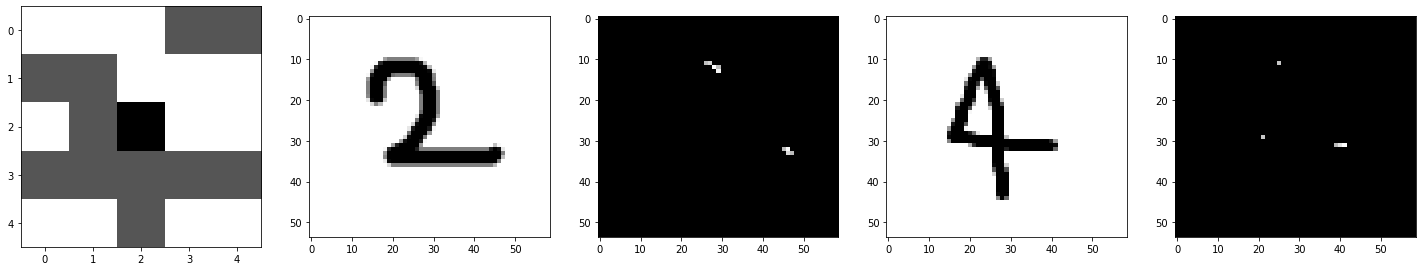

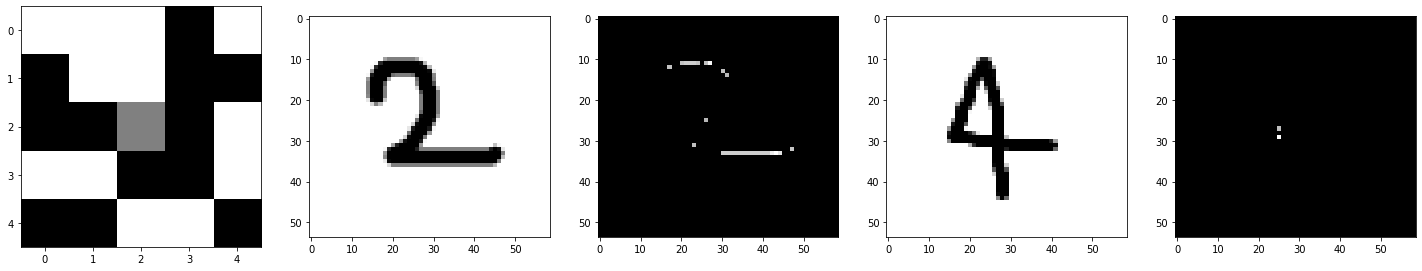

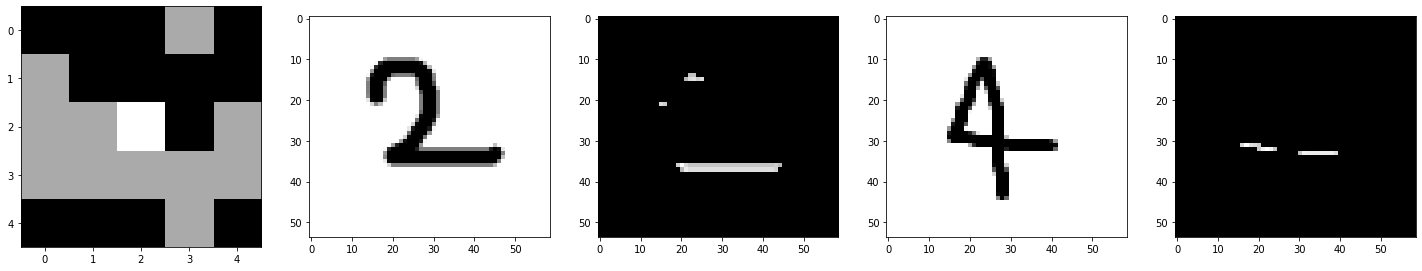

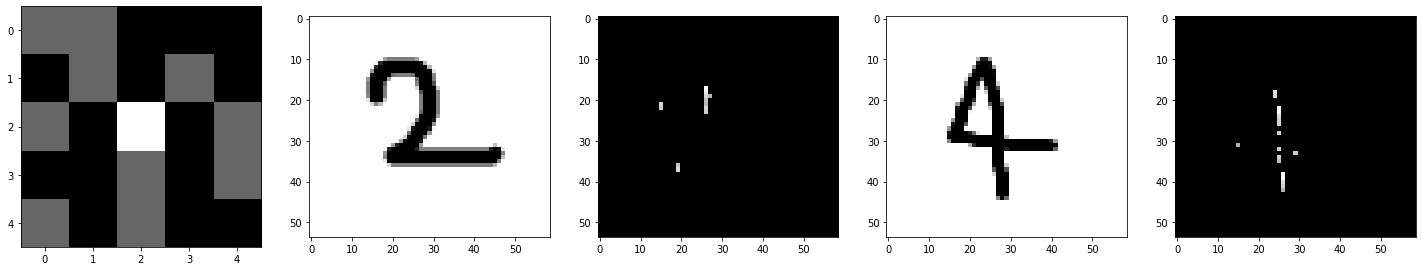

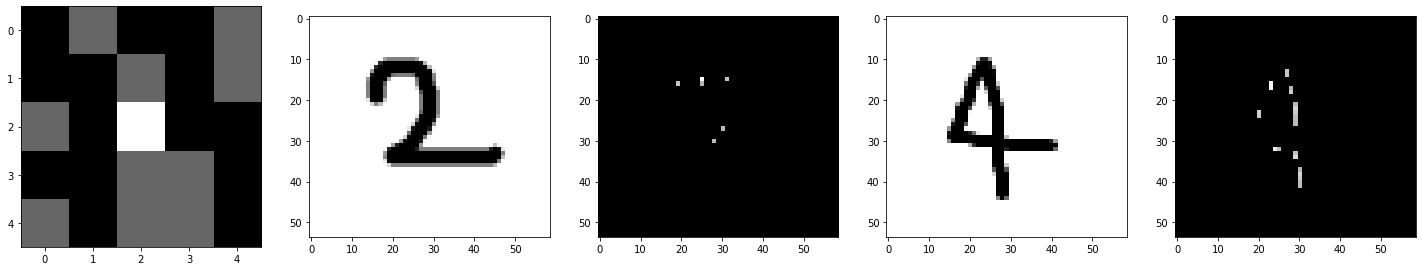

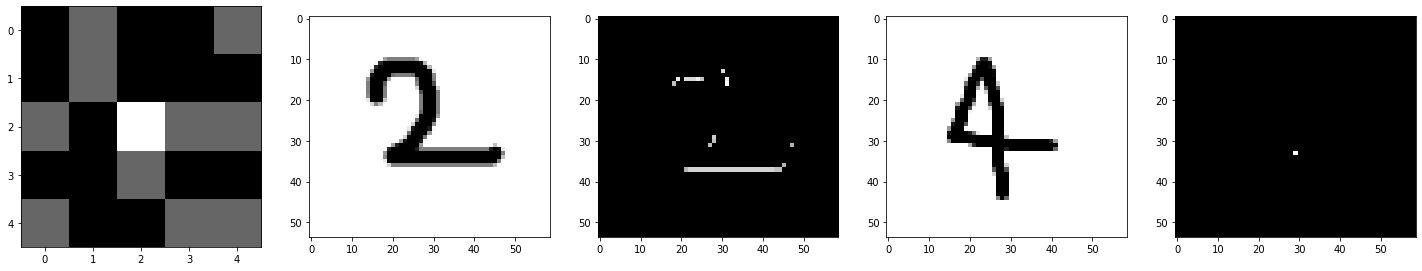

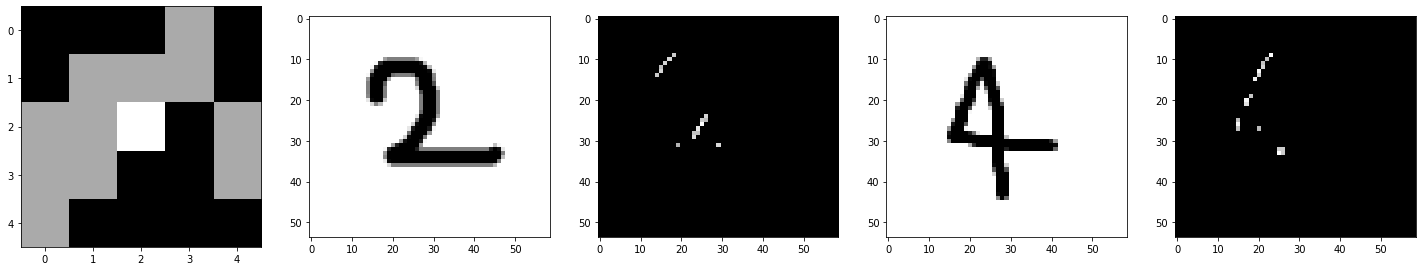

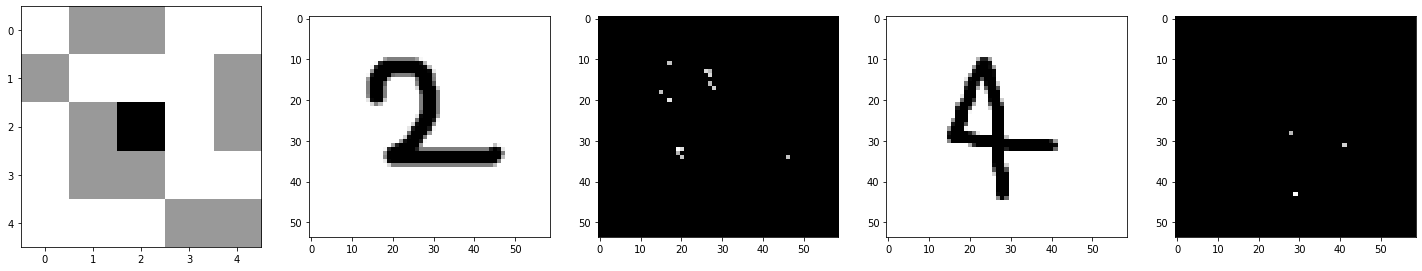

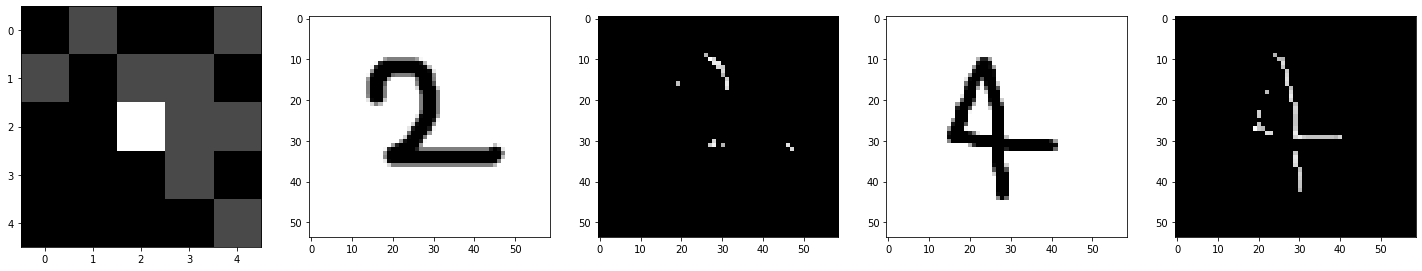

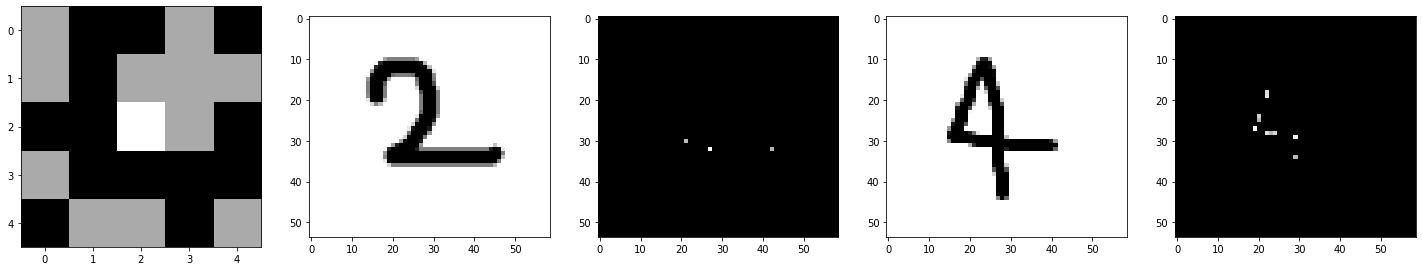

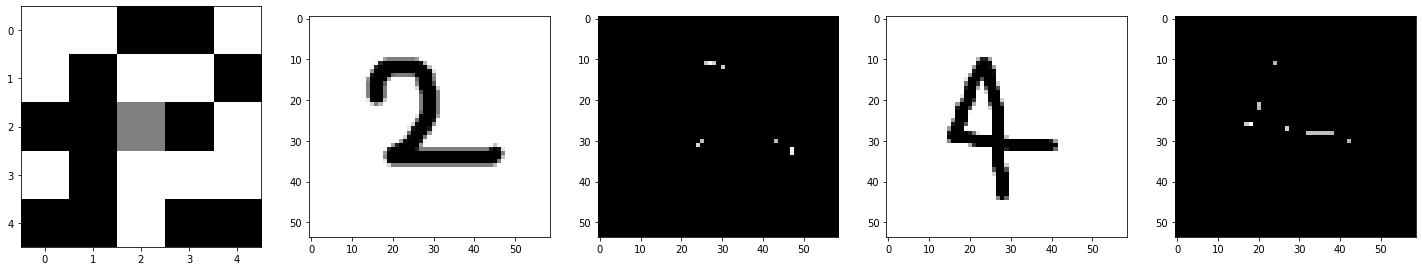

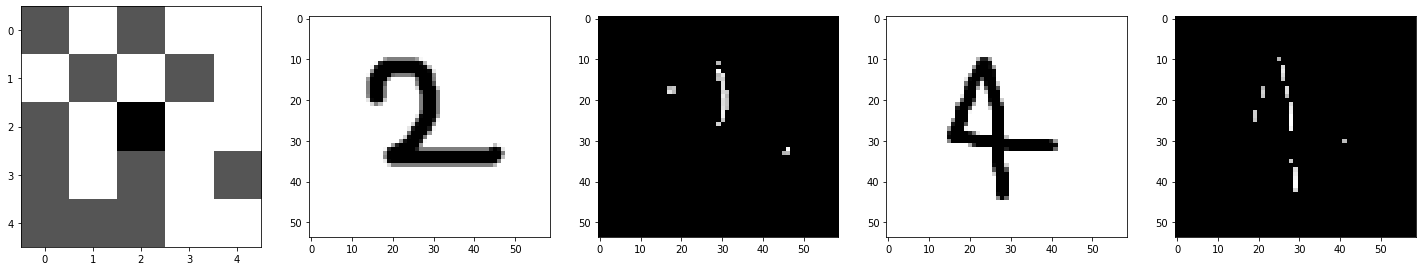

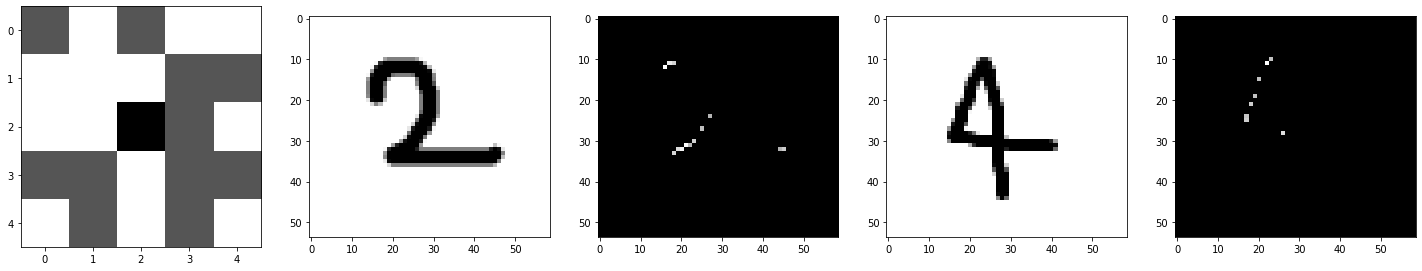

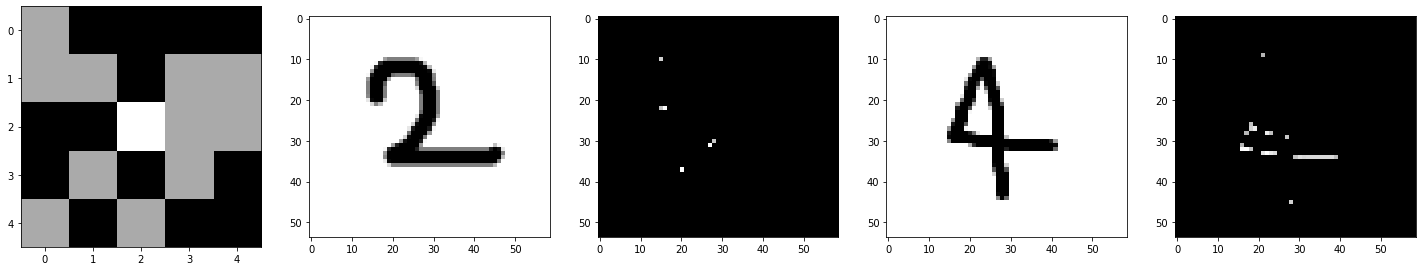

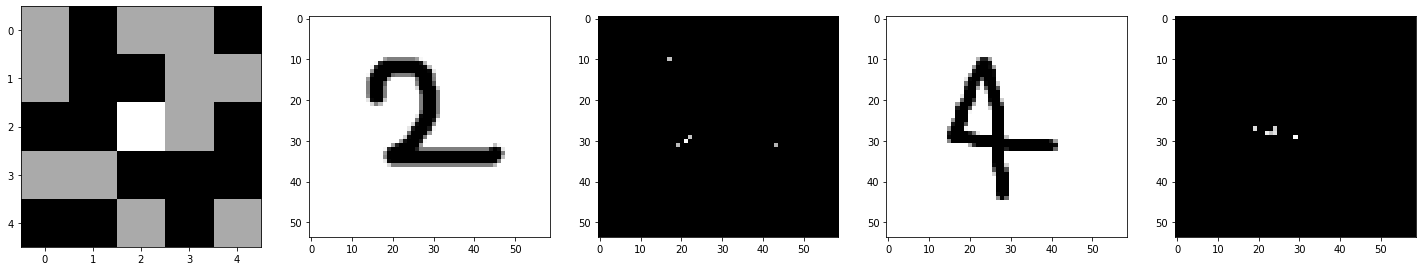

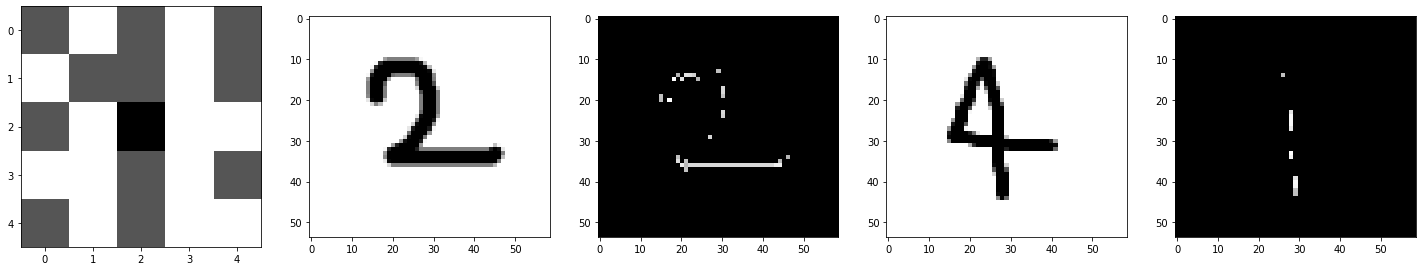

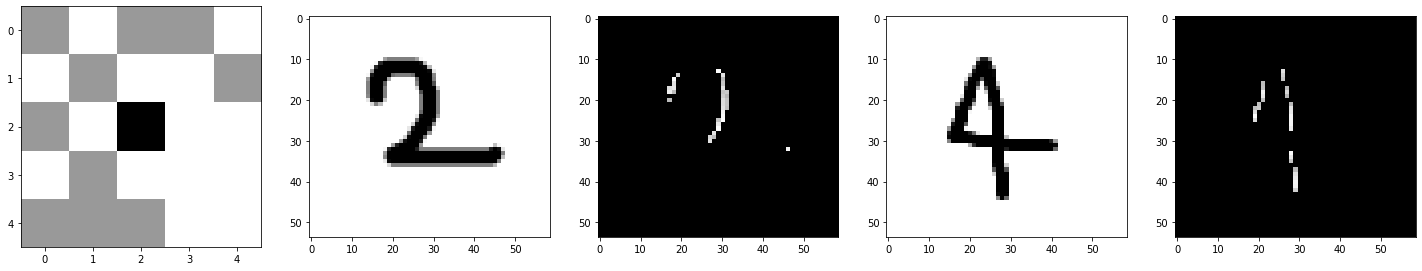

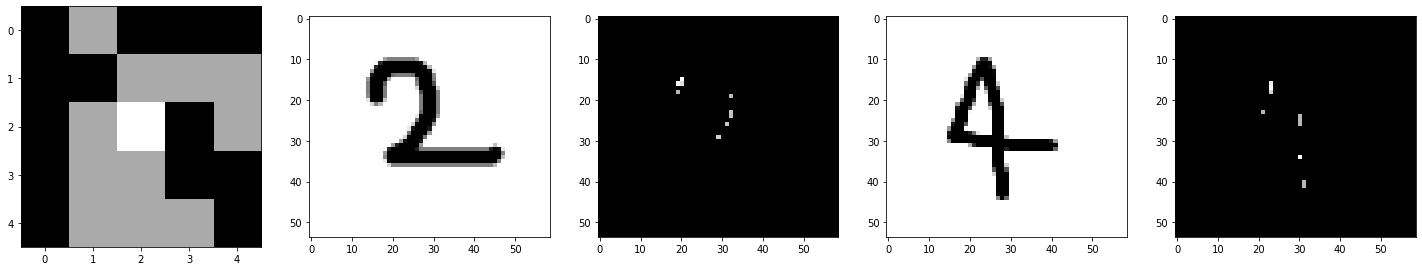

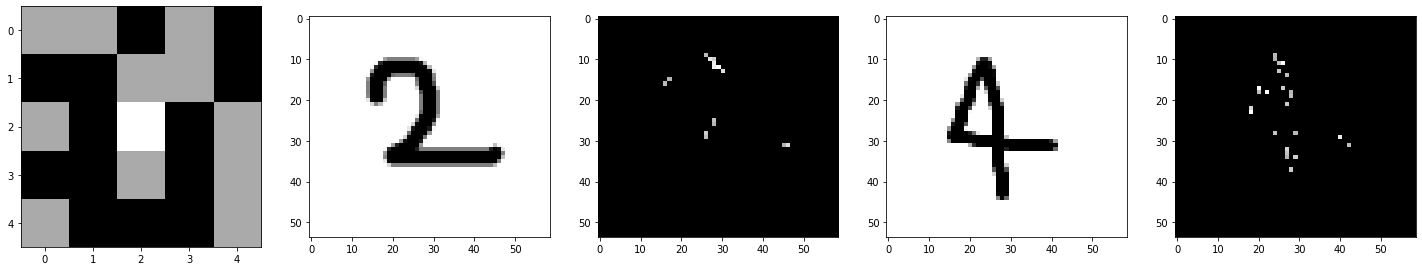

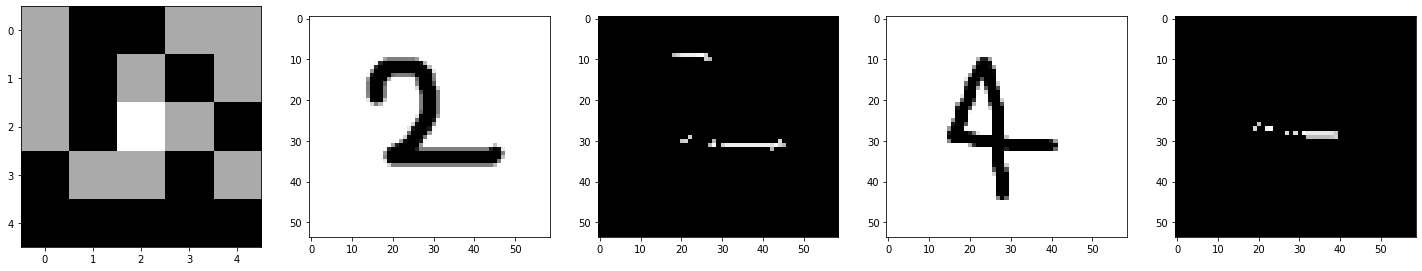

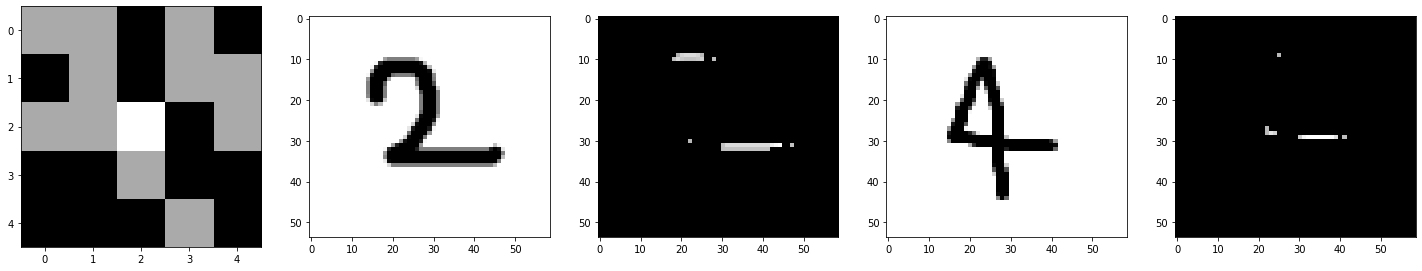

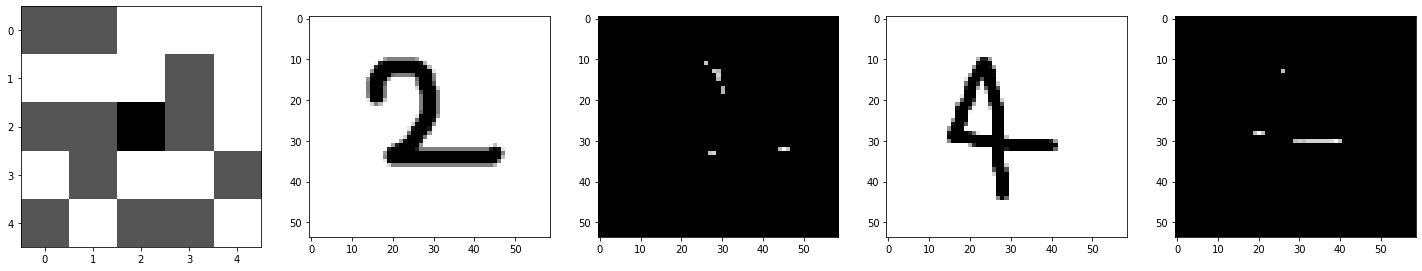

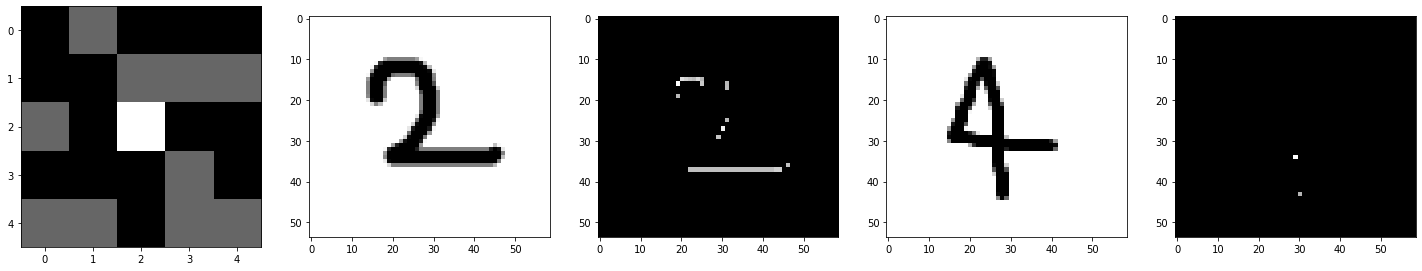

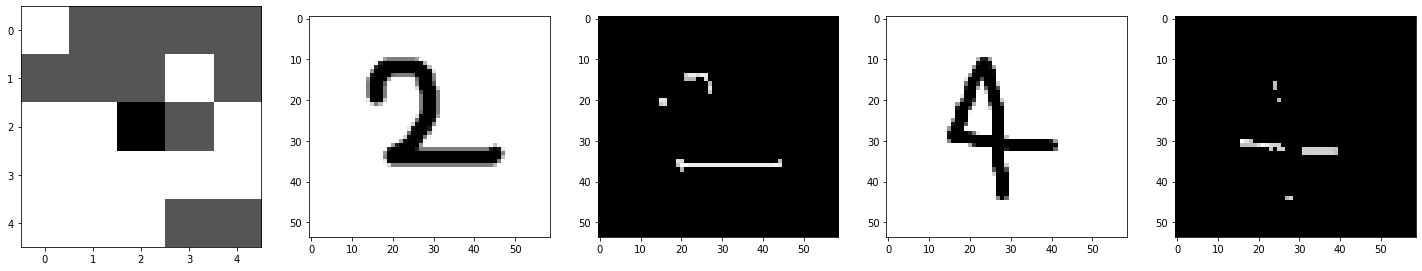

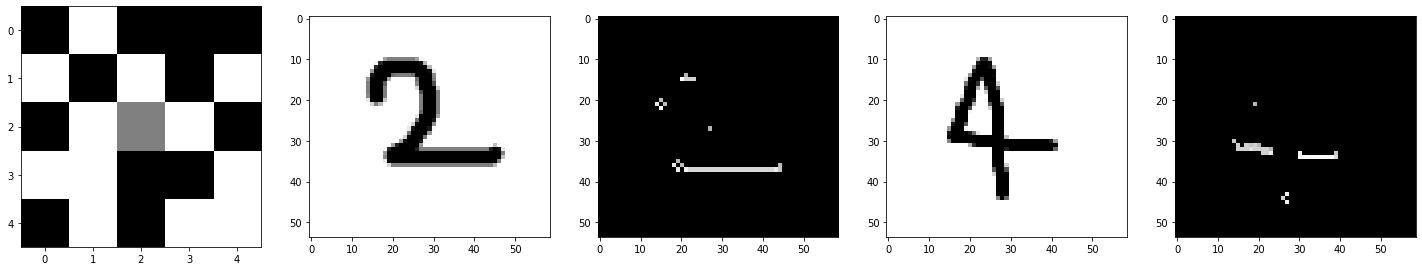

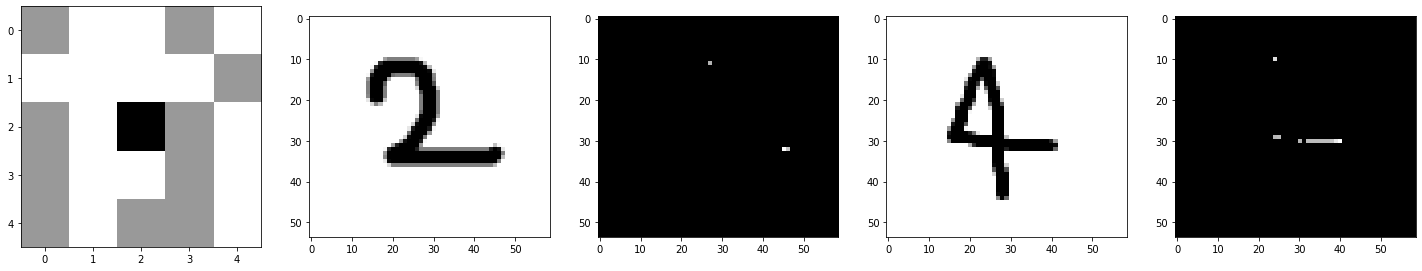

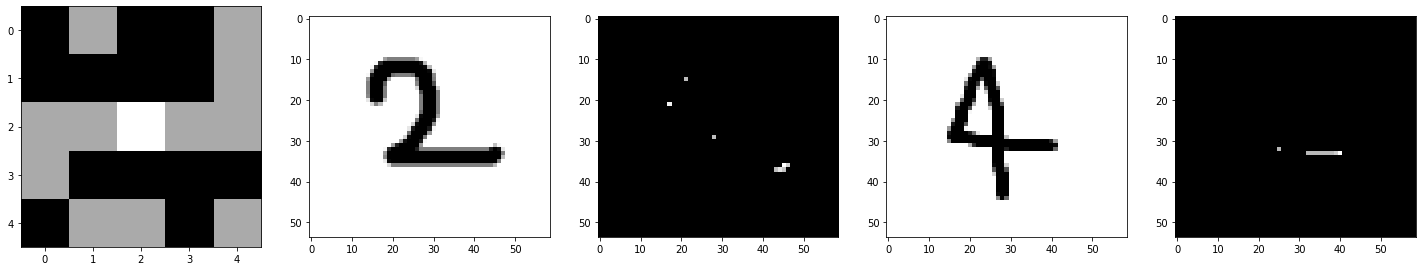

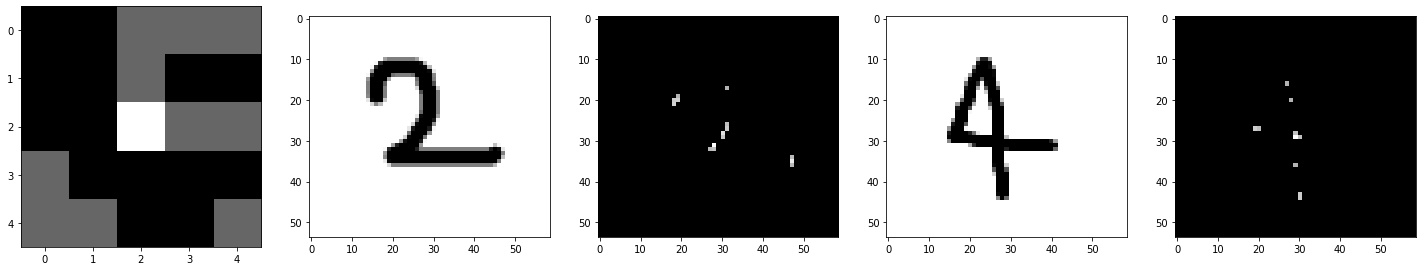

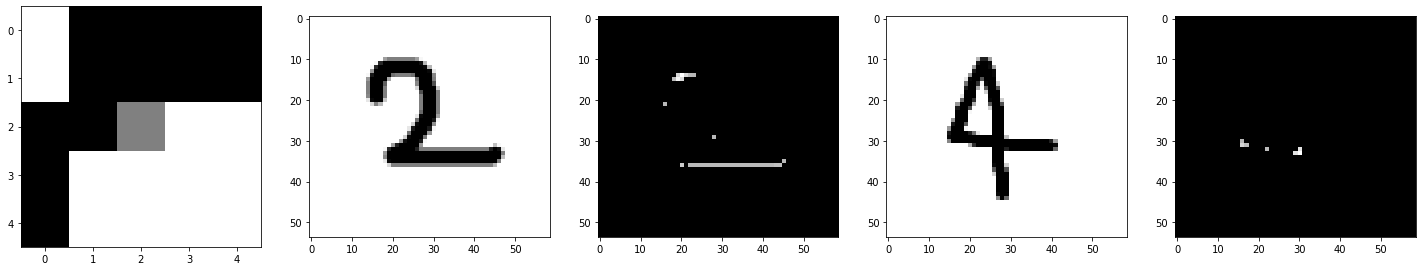

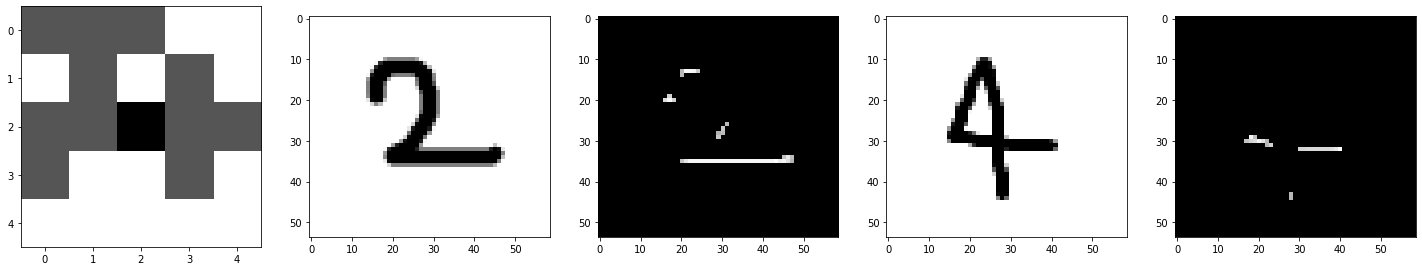

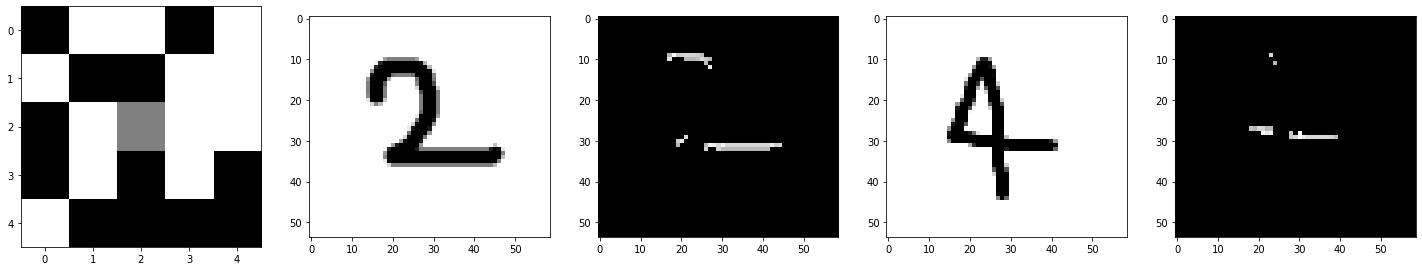

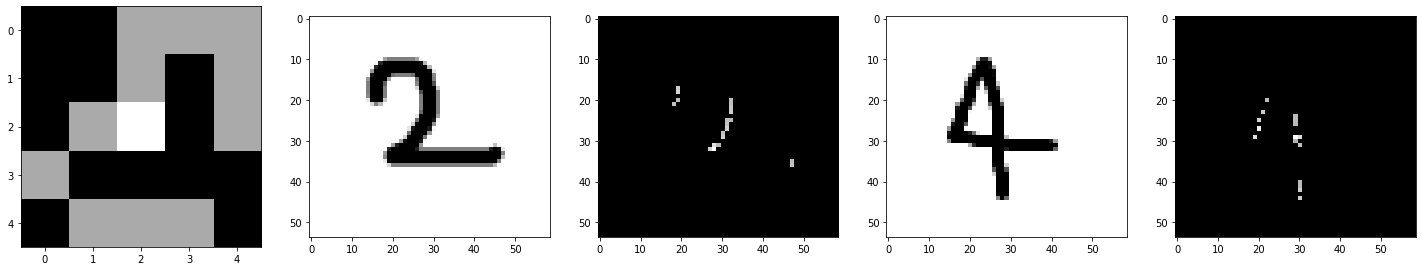

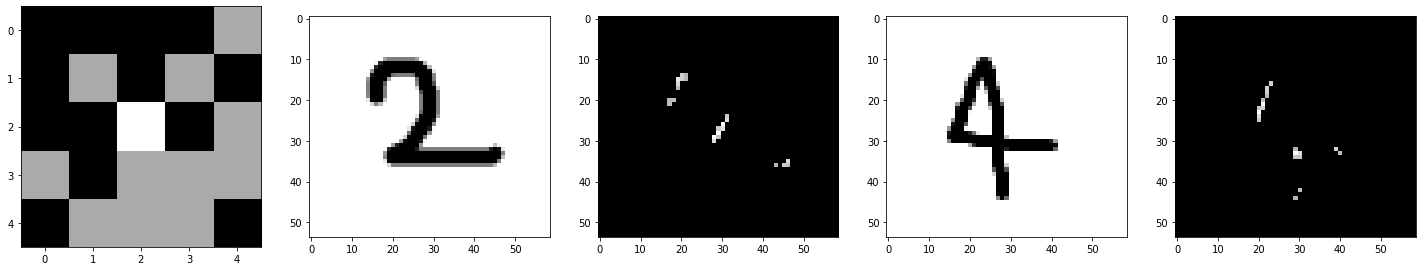

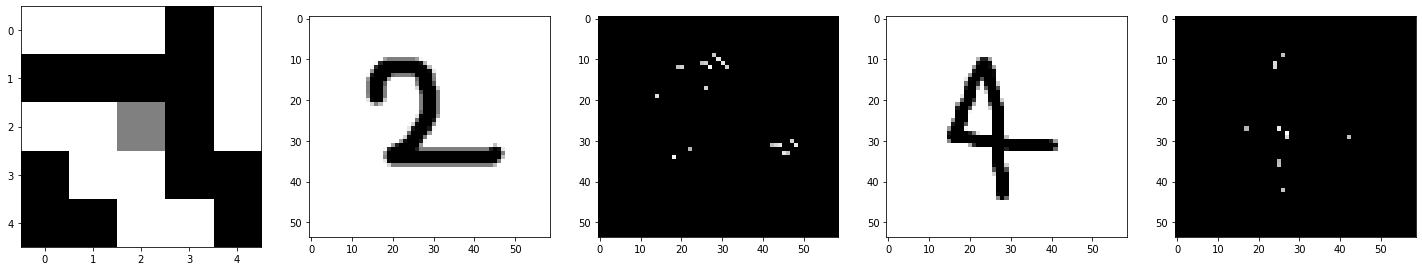

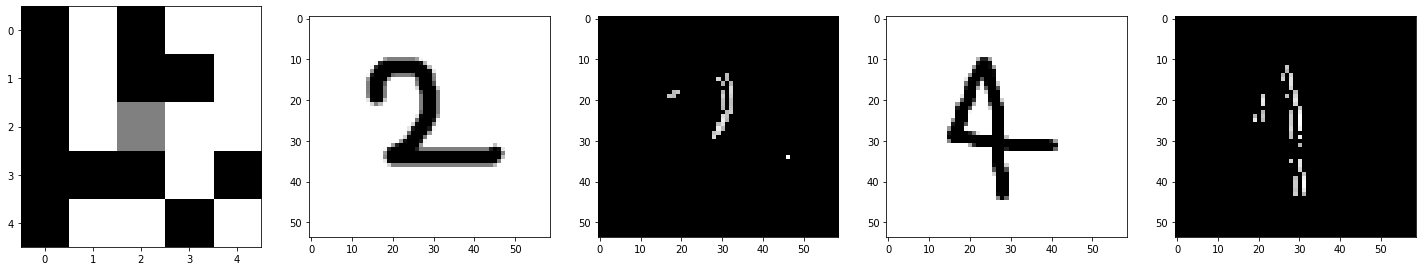

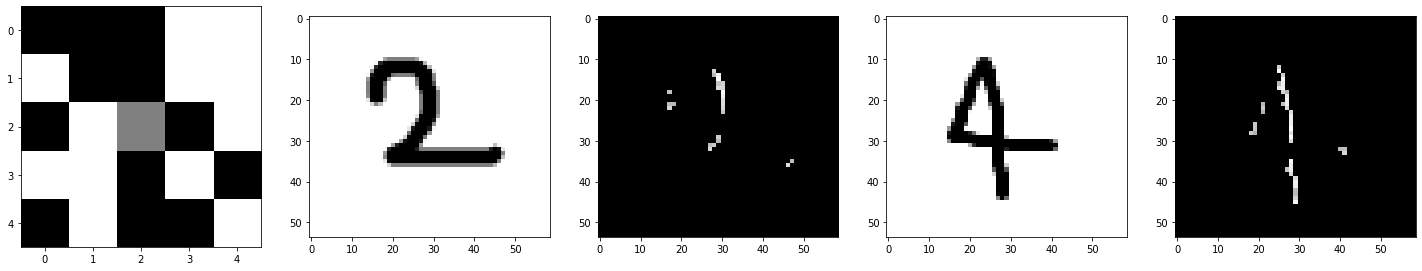

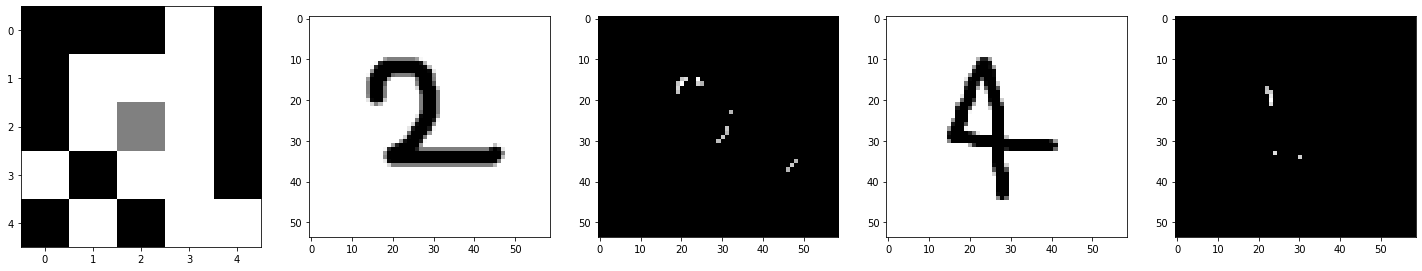

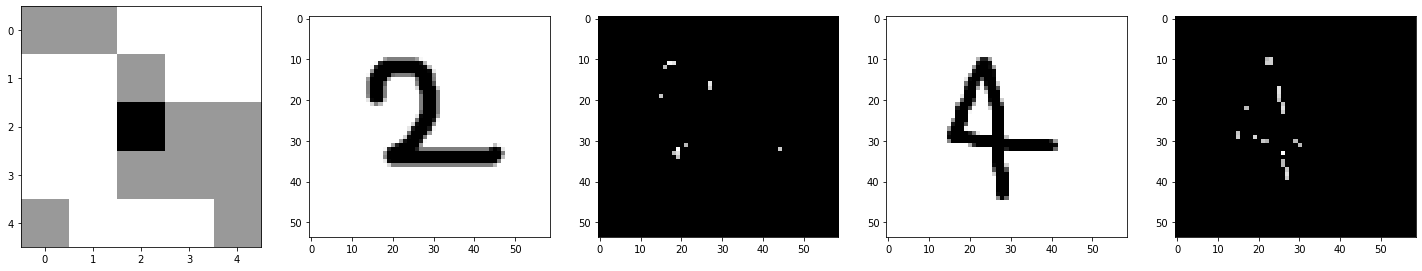

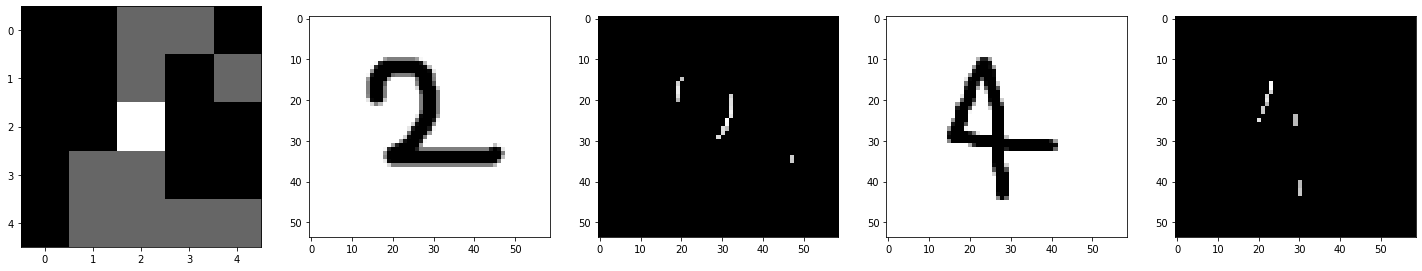

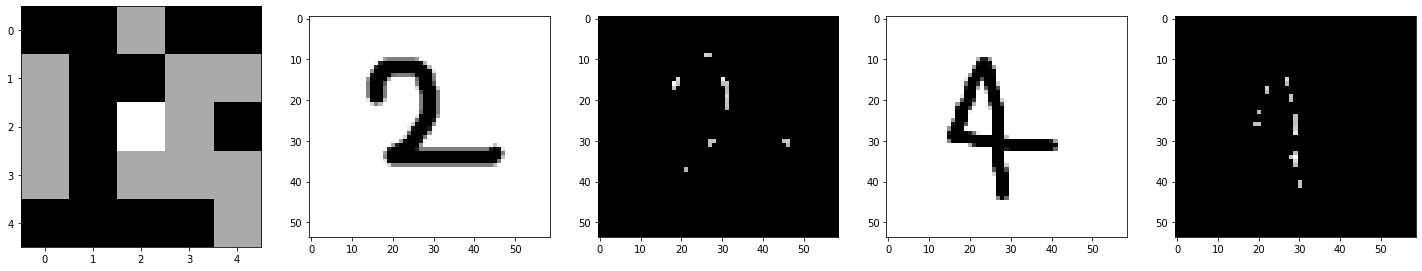

In [112]:
ksize =5
kernelCount = 50
cmap="gray"

dataImg2 = cv.imread(r"D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/2/1649782894.0653417.png",0)
assert dataImg2 is not None
dataImg2 = dataImg2.astype(np.float32)

dataImg4 = cv.imread(r"D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/4/1649783296.5204616.png",0)
assert dataImg4 is not None
dataImg4 = dataImg4.astype(np.float32)

plt.imshow(dataImg2,cmap="gray"),plt.imshow(dataImg4,cmap="gray")



for i in range(kernelCount):
    testKernel = np.random.rand(ksize,ksize)
    testKernel -= np.mean(testKernel)
    testKernel = 2*np.array(testKernel > 0,np.float32) 
    testKernel -= 1
    testKernel[testKernel.shape[0]//2,testKernel.shape[1]//2] -= np.sum(testKernel)
    
    
    filtered2 = cv.filter2D(dataImg2,-1,testKernel)
    filtered4 = cv.filter2D(dataImg4,-1,testKernel)
    
    #cleaning "filtered" : removing not dominant parts then normalizing it
    dominantInFiltered2 = filtered2 > np.max(filtered2) * 0.7
    filtered2 *= dominantInFiltered2
    filtered2 /= np.sum(filtered2)
        
    dominantInFiltered4 = filtered4 > np.max(filtered4) * 0.7
    filtered4 *= dominantInFiltered4
    filtered4 /= np.sum(filtered4)
    
    fig,ax = plt.subplots(1,5,figsize=(25,25))
    ax[2].imshow(filtered2,cmap=cmap)
    ax[1].imshow(dataImg2,cmap=cmap)
    ax[4].imshow(filtered4,cmap=cmap)
    ax[3].imshow(dataImg4,cmap=cmap)
    ax[0].imshow(testKernel,cmap=cmap)
    plt.show()
    
    
    
    

In [106]:
a = np.array([[3,3,6],[5,6,9],[1,2,3]])
scistat.moment(a,moment=2,axis=0)

array([2.66666667, 2.88888889, 6.        ])